# 0.0 Imports

In [1]:
!pip install inflection

In [2]:
import math
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
import datetime
from IPython.display import HTML
from scipy import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder


## 0.1 Helper functions

In [3]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]

    chi2corr = max(0, chi2 - (k-1)* (r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)



    return np.sqrt((chi2corr/n) / min((kcorr-1), (rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data

In [5]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False, sep=',', on_bad_lines='skip')

In [6]:
df_sales_raw.shape

(1017209, 9)

In [7]:
df_store_raw = pd.read_csv('data/store.csv', low_memory = False, sep=',', on_bad_lines='skip' )

In [8]:
df_store_raw.shape

(1115, 10)

In [9]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [10]:
df_raw.shape

(1017209, 18)

In [11]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
718691,302,3,2013-09-25,3234,276,1,1,0,0,d,c,2190.0,12.0,2007.0,1,9.0,2011.0,"Mar,Jun,Sept,Dec"


# 1.0 Passo 1 - Descrição dos dados

## 1.1 Renomear colunas

In [12]:
df1 = df_raw.copy()
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
# modificando nomes das colunas
snakecase = lambda x: inflection.underscore(x)
cols_new=list(map(snakecase, cols_old))
df1.columns = cols_new

## 1.2 Data dimensions

In [13]:
print(f'Linhas: {df1.shape[0]}. Colunas: {df1.shape[1]}')

Linhas: 1017209. Colunas: 18


## 1.3 Data types

In [14]:
df1['date']=pd.to_datetime(df1['date'])
df1.dtypes

,0
store,int64
day_of_week,int64
date,datetime64[ns]
sales,int64
customers,int64
open,int64
promo,int64
state_holiday,object
school_holiday,int64
store_type,object


## 1.4 Check NA

In [15]:
df1.isna().sum()

,0
store,0
day_of_week,0
date,0
sales,0
customers,0
open,0
promo,0
state_holiday,0
school_holiday,0
store_type,0


## 1.5 Fillout NA

In [16]:
df1['competition_distance'].max()

75860.0

In [17]:
#competition_distance
# preenchendo NA com valor grande assumindo que se é NA é porque o copetidor mais próximo está muito longe
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)
#competition_open_since_month
df1['competition_open_since_month'] =df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
#competition_open_since_year
df1['competition_open_since_year'] =df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)


In [18]:
#promo2
#promo2_since_week
df1['promo2_since_week'] =df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] =df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1:'Jan' ,2:'Feb' ,3:'Mar' ,4:'Apr' ,5:'May' ,6:'Jun' ,7:'Jul' ,8:'Aug' ,9:'Sep' ,10:'Oct' ,11:'Nov' ,12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis =1)

<ipython-input-18-94dc6e5ce95a>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['promo_interval'].fillna(0, inplace=True)


In [19]:
df1.sample(5).T

,523595,853941,236503,958673,270433
store,331,637,152,559,467
day_of_week,3,1,3,5,2
date,2014-03-19 00:00:00,2013-05-27 00:00:00,2014-12-31 00:00:00,2013-02-22 00:00:00,2014-11-25 00:00:00
sales,7079,11428,3676,5801,14985
customers,935,768,461,717,1638
open,1,1,1,1,1
promo,1,1,0,1,1
state_holiday,0,0,0,0,0
school_holiday,0,1,1,0,0
store_type,a,d,a,d,a


In [20]:
df1.isna().sum()

,0
store,0
day_of_week,0
date,0
sales,0
customers,0
open,0
promo,0
state_holiday,0
school_holiday,0
store_type,0


## 1.6 Change types

In [21]:
df1.dtypes

,0
store,int64
day_of_week,int64
date,datetime64[ns]
sales,int64
customers,int64
open,int64
promo,int64
state_holiday,object
school_holiday,int64
store_type,object


In [22]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [23]:
df1.dtypes

,0
store,int64
day_of_week,int64
date,datetime64[ns]
sales,int64
customers,int64
open,int64
promo,int64
state_holiday,object
school_holiday,int64
store_type,object


## 1.7 Descriptive statistical

In [24]:
#Separndo colunas de dados numéricos e categóricos
num_attributes = df1.select_dtypes(include=['int32', 'int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int32', 'int64', 'float64', 'datetime64[ns]'])

In [25]:
cat_attributes.sample()

,state_holiday,store_type,assortment,promo_interval,month_map
417483,0,a,c,0,Jun


### Numerical Attributes

In [26]:
# Central tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
# Dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()



In [27]:
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<Axes: xlabel='sales', ylabel='Count'>

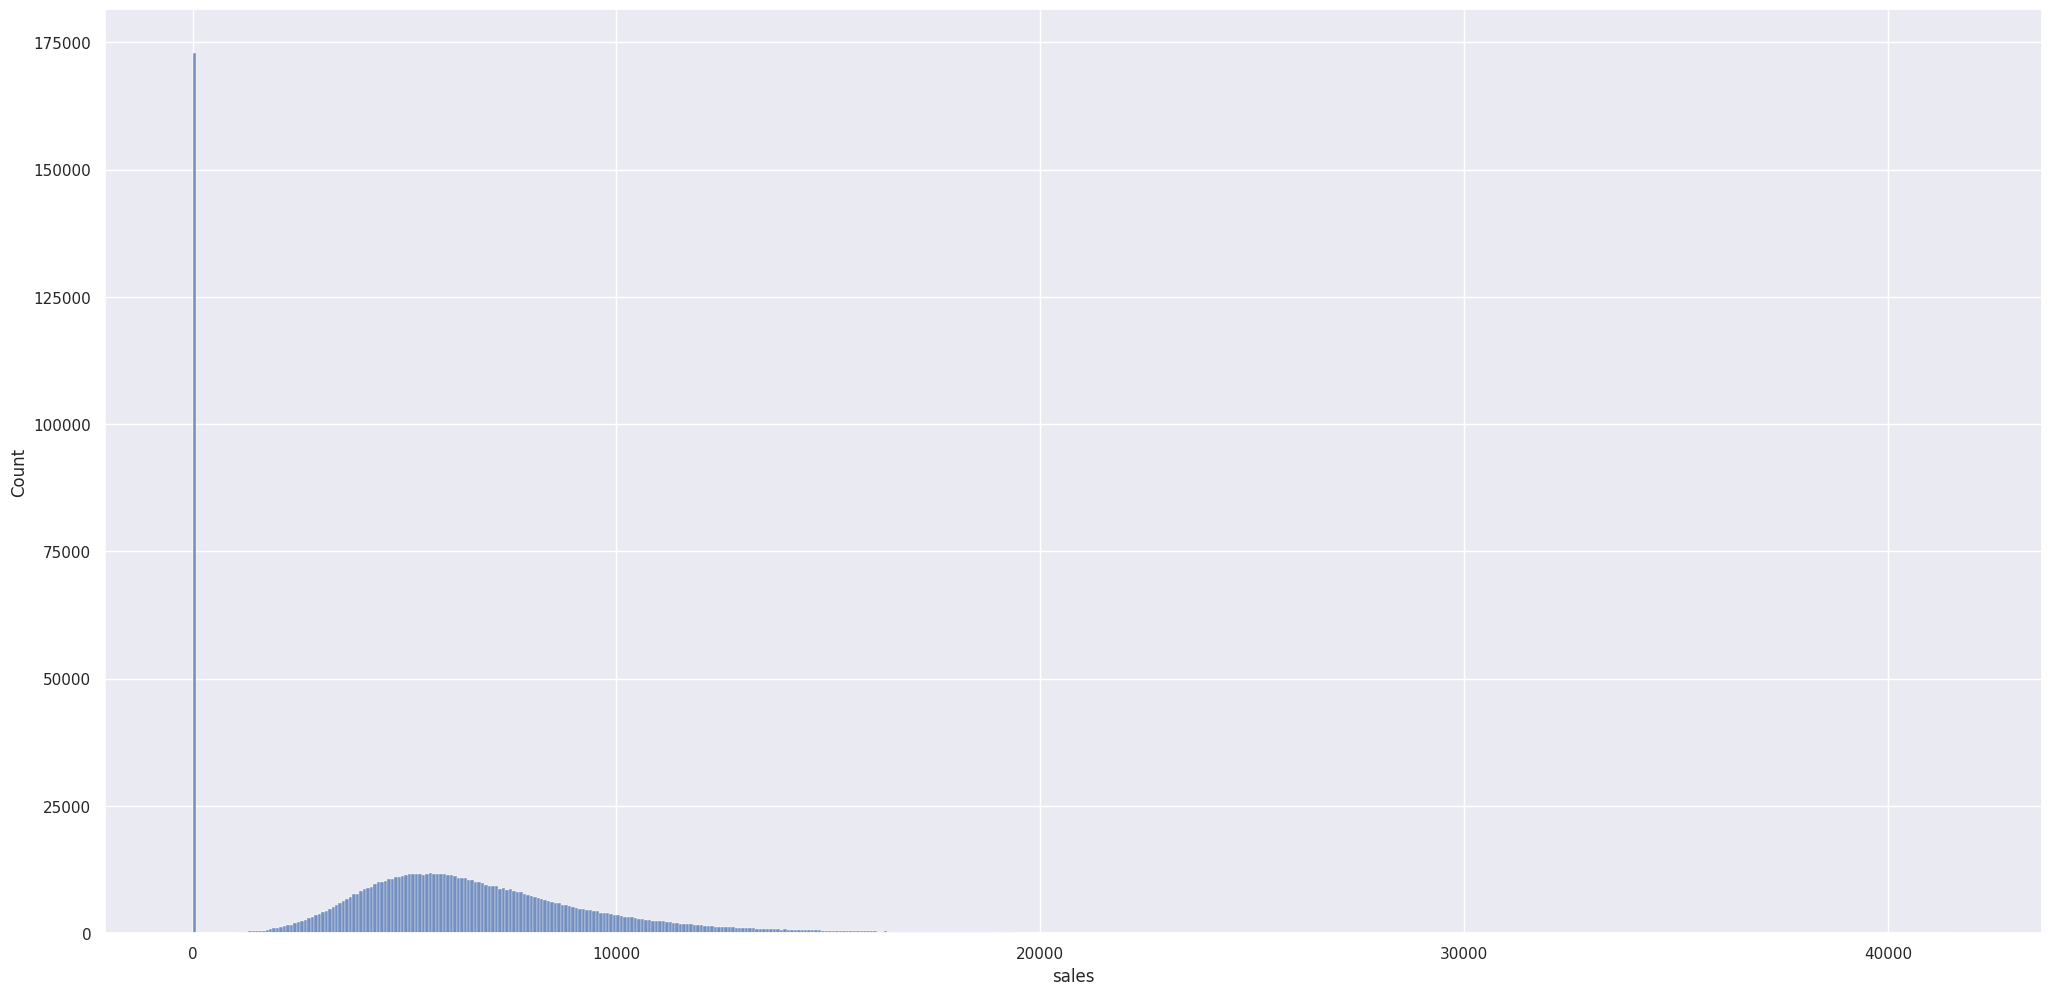

In [28]:
sns.histplot(df1['sales'])

<Axes: xlabel='competition_distance', ylabel='Density'>

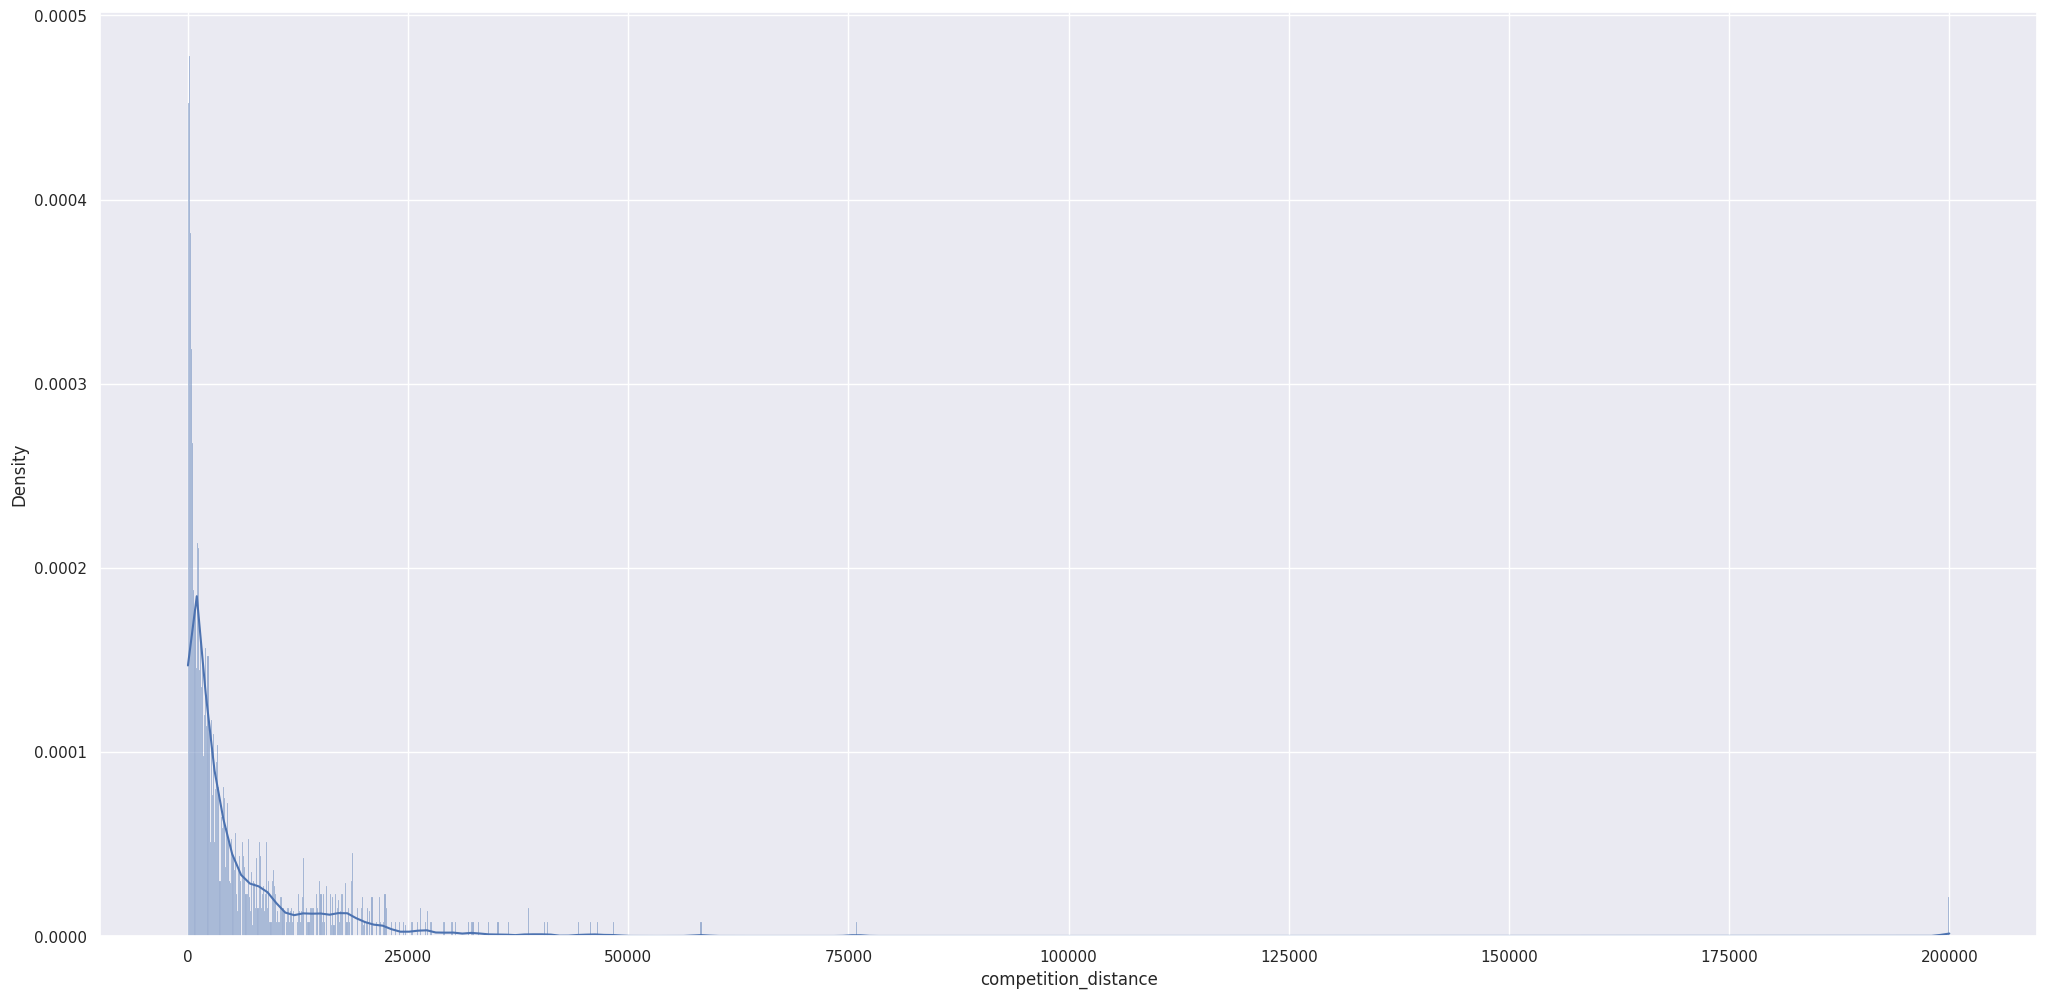

In [29]:
sns.set_theme()
sns.histplot(df1['competition_distance'], kde=True, stat='density')

### 1.7.2 Categorical attributes

In [30]:
cat_attributes.apply(lambda x: x.unique().shape[0])

,0
state_holiday,4
store_type,4
assortment,3
promo_interval,4
month_map,12


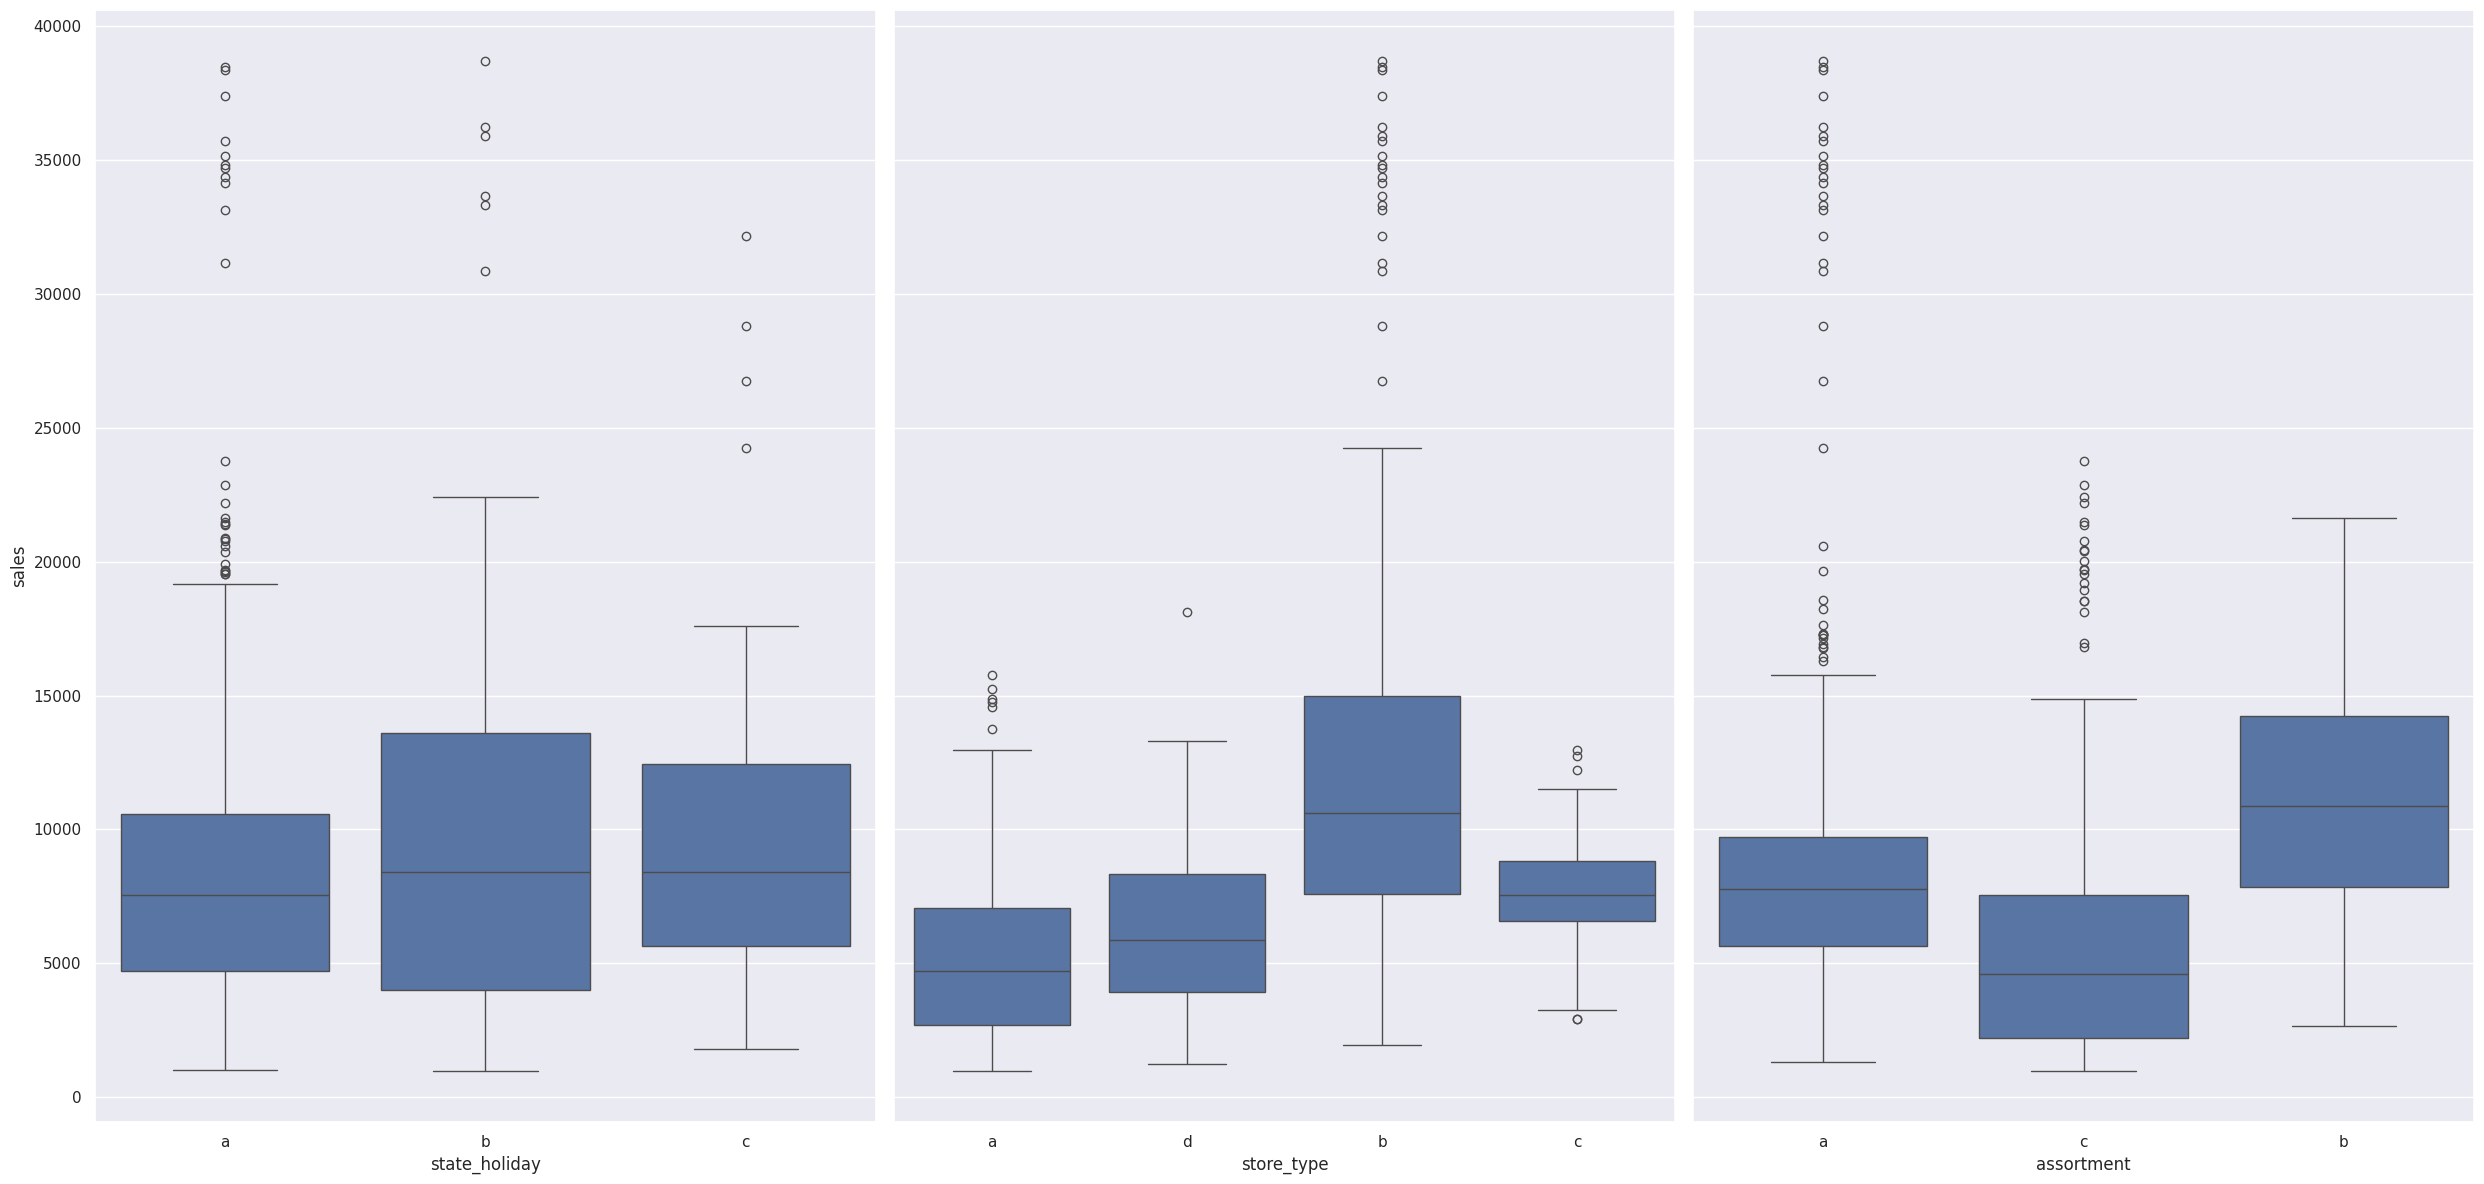

In [31]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data= aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data= aux1)
plt.ylabel('')  # Remove o rótulo 'sales' do eixo Y
plt.gca().set_yticklabels([])  # Remove os valores/ticks do eixo Y

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data= aux1)
plt.ylabel('')  # Remove o rótulo 'sales' do eixo Y
plt.gca().set_yticklabels([])  # Remove os valores/ticks do eixo Y

plt.tight_layout()  # Ajusta o espaçamento entre os gráficos


# 2.0 Passo 2 - Feature Engineering

## 2.1 Mapa mental de hipóteses

In [32]:
Image('img/DAILY_STORE_SALES.png')

FileNotFoundError: No such file or directory: 'img/DAILY_STORE_SALES.png'

FileNotFoundError: No such file or directory: 'img/DAILY_STORE_SALES.png'

<IPython.core.display.Image object>

## 2.1.0 Criação das hipóteses

### 2.1.1 Hipóteses Loja

1. Lojas com maior quadro de funcionários deveriam vender mais
2. Lojas com maior estoque deveriam vender mais
3. Lojas com maior porte deveriam vender mais
4. Lojas com maior sortimento deveriam vender mais

### 2.1.2 Hipóteses Produto

1. Produtos que recebem mais investimento de marketing deveriam vender mais
2. Lojas que expõem mais os produtos em vitrine deveriam vender mais
3. Lojas que possuem preços menores nos produtos deveriam vender mais
4. Lojas que tem preços menores nos produtos por mais tempo deveriam vender mais
   

### 2.1.1 Hipóteses Tempo (Sazonalidade)

1. Lojas com mais feriados deveriam vender menos
2. Lojas que abrem nos últimos 6 meses deveriam vender mais
3. Lojas que abrem nos finais de semana deveriam vender mais

## 2.2 Lista final de hipóteses

Filtrar hipóteses com base no critério de haver ou não dados que possam validar/refutar a hipótese

1. Lojas com maior sortimento deveriam vender mais
2. Lojas com competidores mais próximos deveriam vender menos
3. Lojas com competidores há mais tempo deveriam vender menos

4. Lojas com promoções ativas por mais tempo deveriam vender mais
5. Lojas com mais dias de promoção deveriam vender mais
6. Lojas com mais promoçoes consecutivas deveriam vender mais

7. Lojas com mais feriados deveriam vender menos
8. Lojas que abrem nos últimos 6 meses deveriam vender mais
9. Lojas que abrem nos finais de semana deveriam vender mais

## 2.3 Feature Engineering

In [33]:
df2 = df1.copy()

In [34]:
#year
df2['year']=df2['date'].dt.year
#month
df2['month']=df2['date'].dt.month
#day
df2['day']=df2['date'].dt.day
#week of year
df2['week_of_year']=df2['date'].dt.isocalendar().week
#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


In [35]:
#competition since
df2['competition_since'] =df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month=x['competition_open_since_month'] ,day=1 ), axis = 1)
df2['competition_time_month'] =(df2['date'] - df2['competition_since']).apply(lambda x: (x.days)/30).astype(int)
##promo since
df2['promo_since'] =df2['promo2_since_year'].astype(str) +'-'+ df2['promo2_since_week'].astype(str)
df2['promo_since'] =df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x +'-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] =((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)
#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
#state holiday
df2['state_holiday'] =df2['state_holiday'].apply(lambda x : 'public_holiday' if x == 'a' else 'easter_holiday' if x== 'b' else 'christmas' if x== 'c' else 'regular_day')

In [36]:

df_t= ((df2.loc[0:5, 'date'] - df2.loc[0:5, 'competition_since']).apply(lambda x: (x.days)/30)).astype(int)
df_t
#df2.loc[0:5 , 'date']

,0
0,84
1,94
2,105
3,71
4,4
5,20


In [37]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [38]:
df2.dtypes

,0
store,int64
day_of_week,int64
date,datetime64[ns]
sales,int64
customers,int64
open,int64
promo,int64
state_holiday,object
school_holiday,int64
store_type,object


# 3.0 Passo 3 - Filtragem de variáveis

In [39]:
df3 = df2.copy()

In [40]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.1 Seleção das linhas
Remover as linhas onde as lojas não estavam abertas e que não tiveram vendas. Pois só intressam linhas com vendas.

In [41]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

In [42]:
df3['sales'].min()

46

## 3.2 Seleção das colunas
Remover colunas que não vão poder contribuir com a previsão no momento da previsão.
Embora a coluna customers contenha dados, quando for o momento de realmente fazer a previsão, não há como saber quantos clientes fariam compras nas lojas no futuro. Pra isso, teria que se fazer outro projeto de previsão de clientes e então usar esse valor como input na coluna customers.
Exclui a coluna open pois uma vez que tenha excluido linhas com open != 0, já não tem informação relevante.
Excluir colunas que foram usadas como auxiliares ou das quais se derivou outra coluna.

In [43]:
cols_drop= ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [44]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Passo 04 - Análise Exploratória de Dados

In [45]:
df4 = df3.copy()

In [46]:
#Separndo colunas de dados numéricos e categóricos
num_attributes = df4.select_dtypes(include=['int32', 'int64', 'float64'])
cat_attributes = df4.select_dtypes(exclude=['int32', 'int64', 'float64', 'datetime64[ns]'])

## 4.1 Análise univariada

### 4.1.1 Response variable

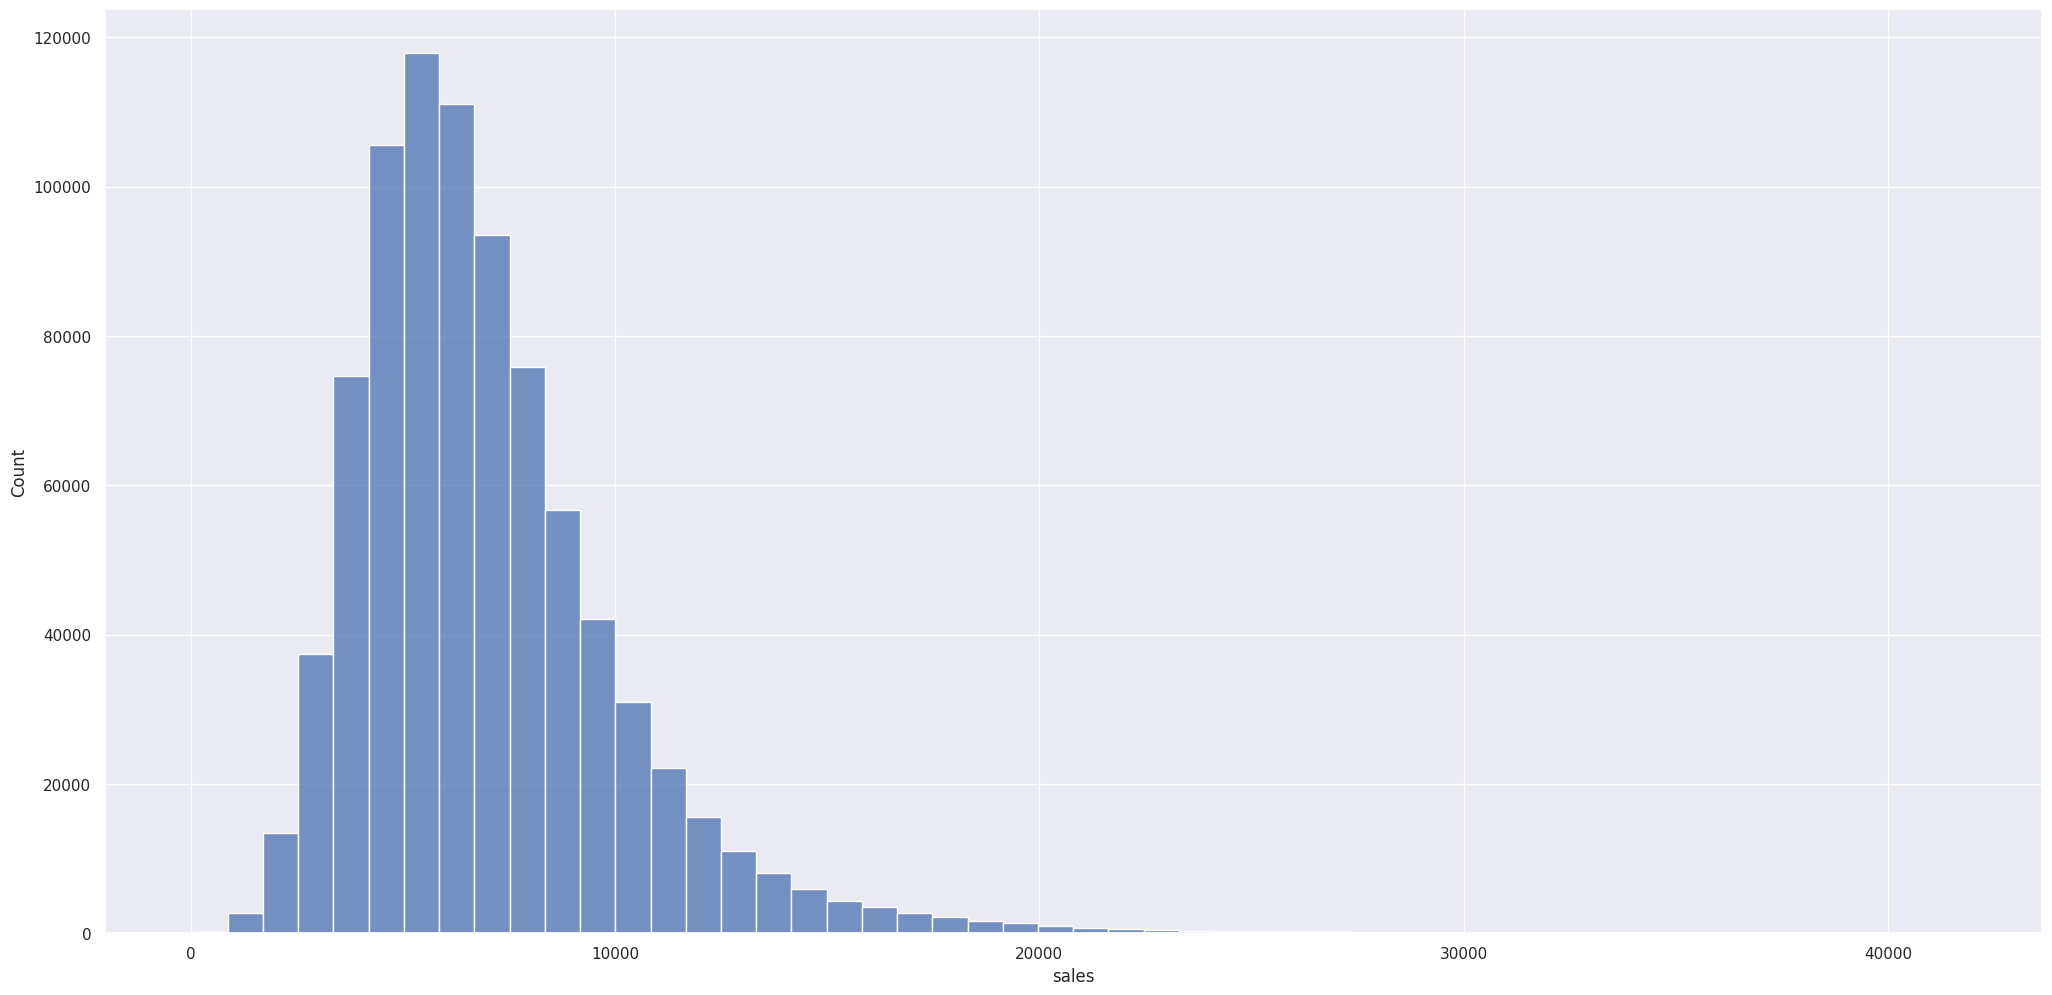

In [47]:
sns.histplot(df4['sales'], bins = 50);

### 4.1.2 Numerical variable

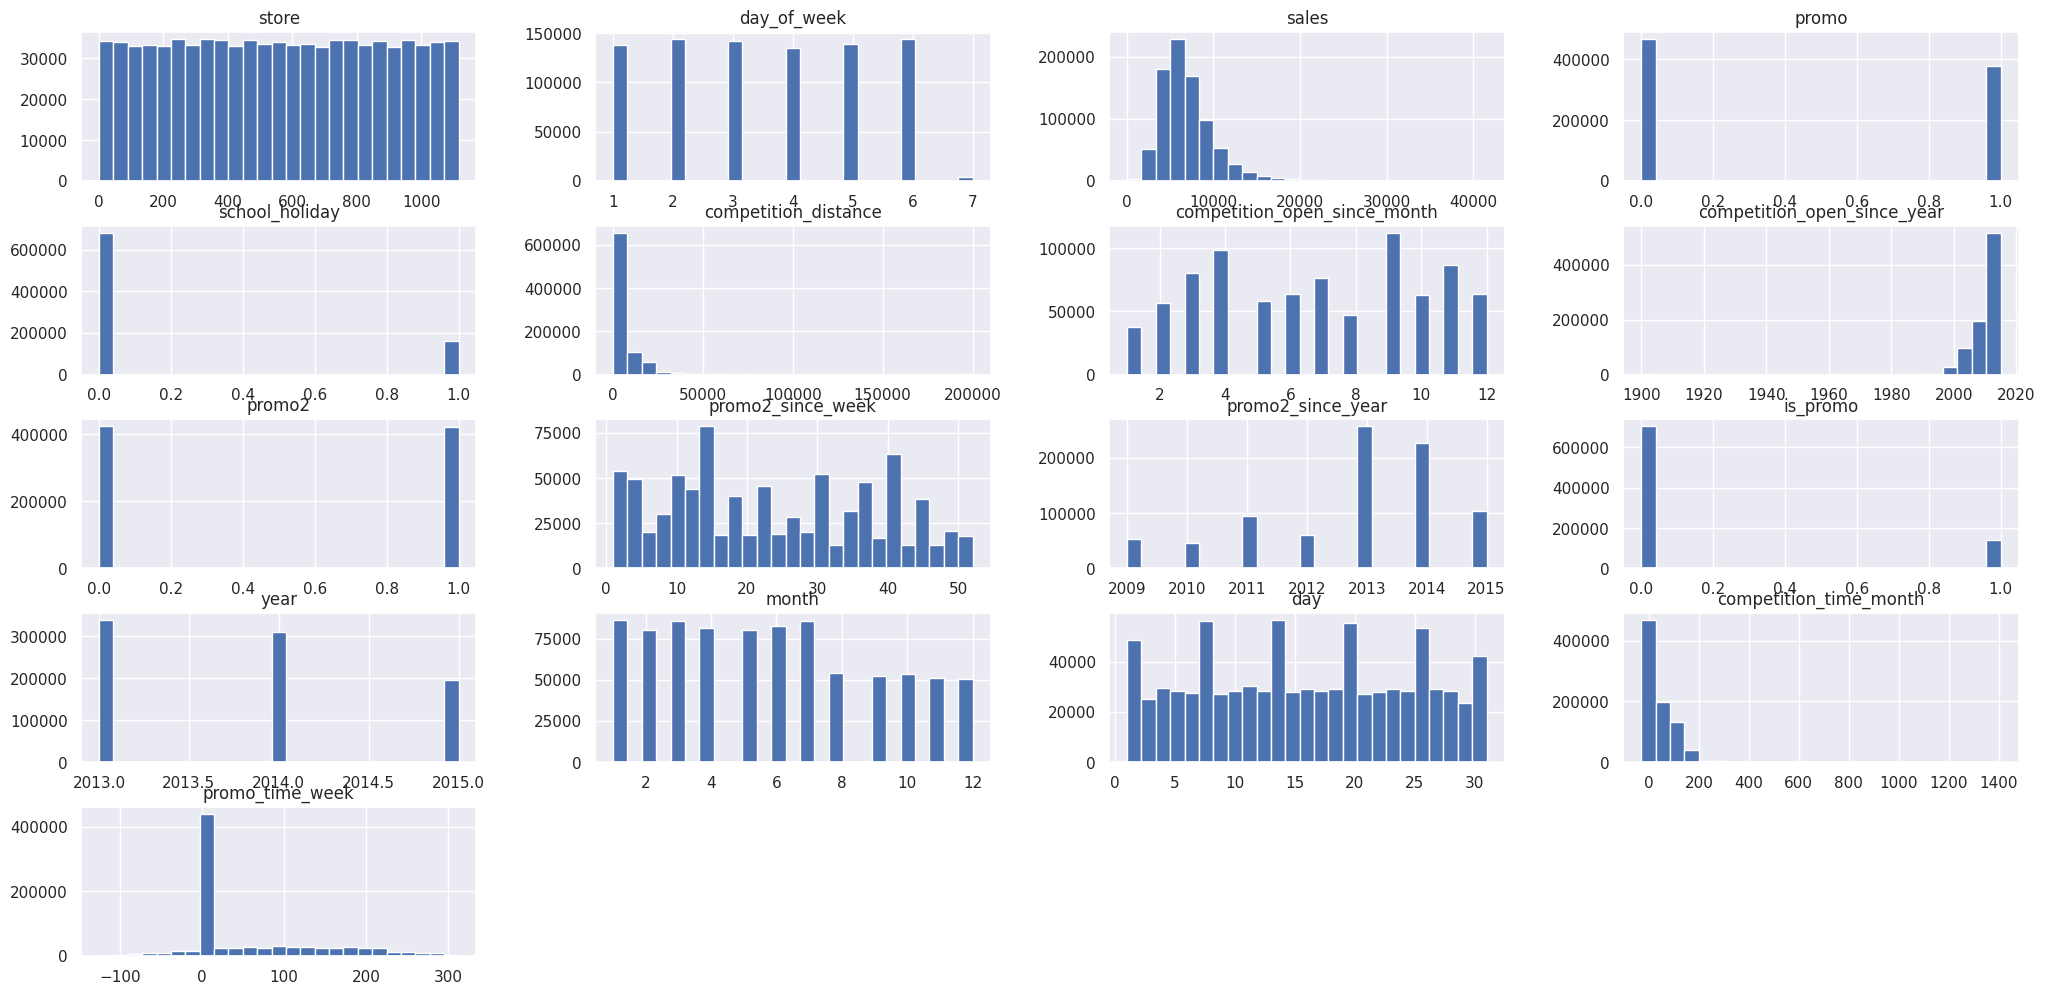

In [48]:
num_attributes.hist(bins = 25);

In [49]:
num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
store,844338.0,558.421374,321.730861,1.0,280.0,558.0,837.0,1115.0
day_of_week,844338.0,3.520350,1.723712,1.0,2.0,3.0,5.0,7.0
sales,844338.0,6955.959134,3103.815515,46.0,4859.0,6369.0,8360.0,41551.0
promo,844338.0,0.446356,0.497114,0.0,0.0,0.0,1.0,1.0
school_holiday,844338.0,0.193578,0.395102,0.0,0.0,0.0,0.0,1.0
competition_distance,844338.0,5961.827515,12592.181107,20.0,710.0,2330.0,6910.0,200000.0
competition_open_since_month,844338.0,6.787355,3.309917,1.0,4.0,7.0,10.0,12.0
competition_open_since_year,844338.0,2010.331102,5.502628,1900.0,2008.0,2012.0,2014.0,2015.0
promo2,844338.0,0.498670,0.499999,0.0,0.0,0.0,1.0,1.0
promo2_since_week,844338.0,23.629083,14.288315,1.0,12.0,22.0,37.0,52.0


### 4.1.3 Categorical variable

In [50]:
df4['state_holiday'].drop_duplicates()

,state_holiday
0,regular_day
63559,public_holiday
129424,easter_holiday
241126,christmas


In [51]:
df4['store_type'].drop_duplicates()

,store_type
0,c
1,a
12,d
84,b


<ipython-input-52-9ee393fd7814>:5: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.countplot(data = a, x= 'state_holiday', hue='state_holiday', palette = palette
<ipython-input-52-9ee393fd7814>:17: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.countplot(data = df4, x= 'store_type', hue = 'store_type', palette = palette
<ipython-input-52-9ee393fd7814>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = df4, x= 'assortment', palette = palette
<ipython-input-52-9ee393fd7814>:30: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.countplot(data = df4, x= 'assortment', palette = palette


<Axes: xlabel='sales', ylabel='Density'>

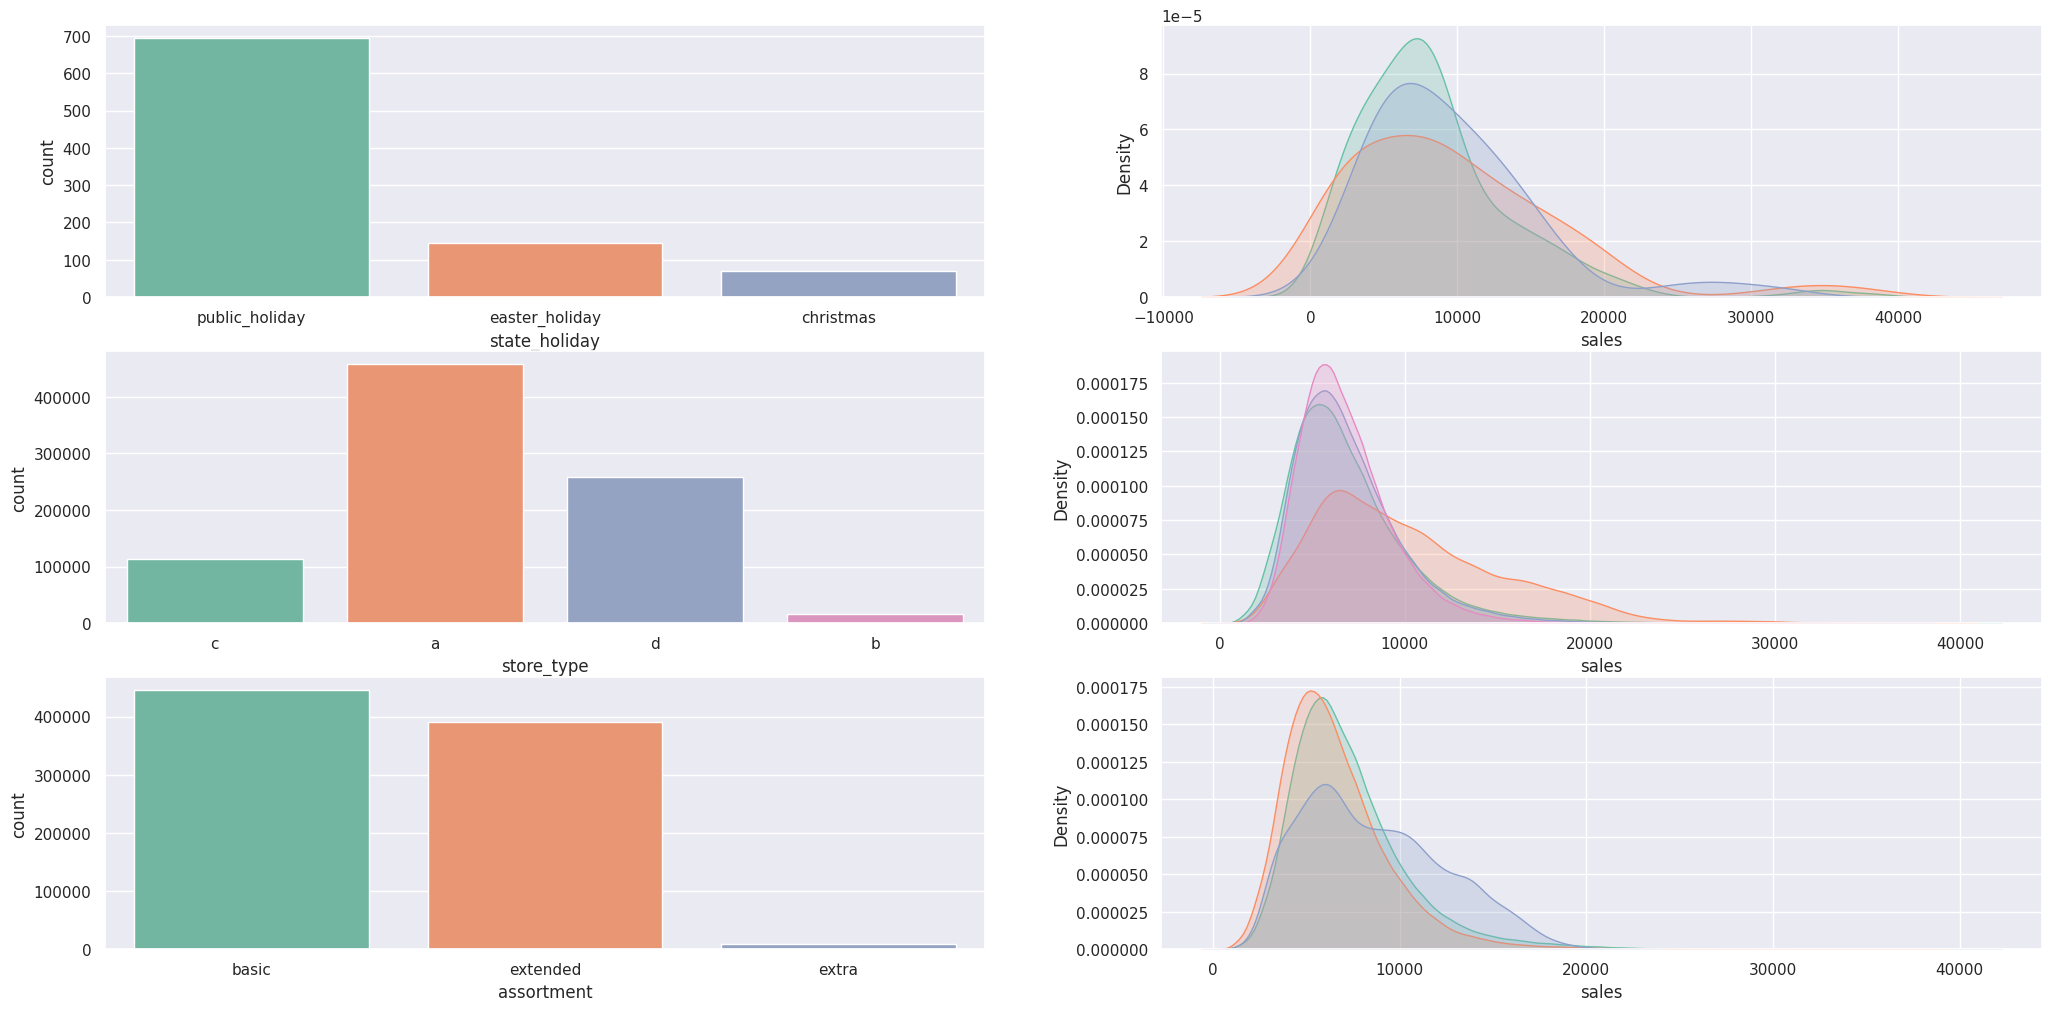

In [52]:
palette = sns.color_palette('Set2')
# state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(data = a, x= 'state_holiday', hue='state_holiday', palette = palette
 );

plt.subplot(3,2,2)
sns.kdeplot(data = df4[df4['state_holiday'] == 'public_holiday']['sales'], label= 'public_holiday', fill = True, color = palette[0] )
sns.kdeplot(data = df4[df4['state_holiday'] == 'easter_holiday']['sales'], label= 'easter_holiday', fill = True, color = palette[1] )
sns.kdeplot(data = df4[df4['state_holiday'] == 'christmas']['sales'], label= 'christmas', fill = True, color = palette[2]  )

#store_type

plt.subplot(3,2,3)

sns.countplot(data = df4, x= 'store_type', hue = 'store_type', palette = palette
 );

plt.subplot(3,2,4)
sns.kdeplot(data = df4[df4['store_type'] == 'a']['sales'], label= 'a', fill = True, color = palette[0])
sns.kdeplot(data = df4[df4['store_type'] == 'b']['sales'], label= 'b', fill = True, color = palette[1])
sns.kdeplot(data = df4[df4['store_type'] == 'c']['sales'], label= 'c', fill = True, color = palette[2])
sns.kdeplot(data = df4[df4['store_type'] == 'd']['sales'], label= 'd', fill = True, color = palette[3])

#assortment

plt.subplot(3,2,5)

sns.countplot(data = df4, x= 'assortment', palette = palette
 );

plt.subplot(3,2,6)
sns.kdeplot(data = df4[df4['assortment'] == 'extended']['sales'], label= 'extended', fill = True, color = palette[0])
sns.kdeplot(data = df4[df4['assortment'] == 'basic']['sales'], label= 'basic', fill = True, color = palette[1])
sns.kdeplot(data = df4[df4['assortment'] == 'extra']['sales'], label= 'extra', fill = True, color = palette[2])




## 4.2 Análise bivariada

### H1 - Lojas com maior sortimento deveriam vender mais
* Falsa. Lojas com maior sortimento vendem menos

<ipython-input-53-919500b51677>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'assortment', y= 'sales', data=aux1, palette = palette);
<ipython-input-53-919500b51677>:2: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(x = 'assortment', y= 'sales', data=aux1, palette = palette);


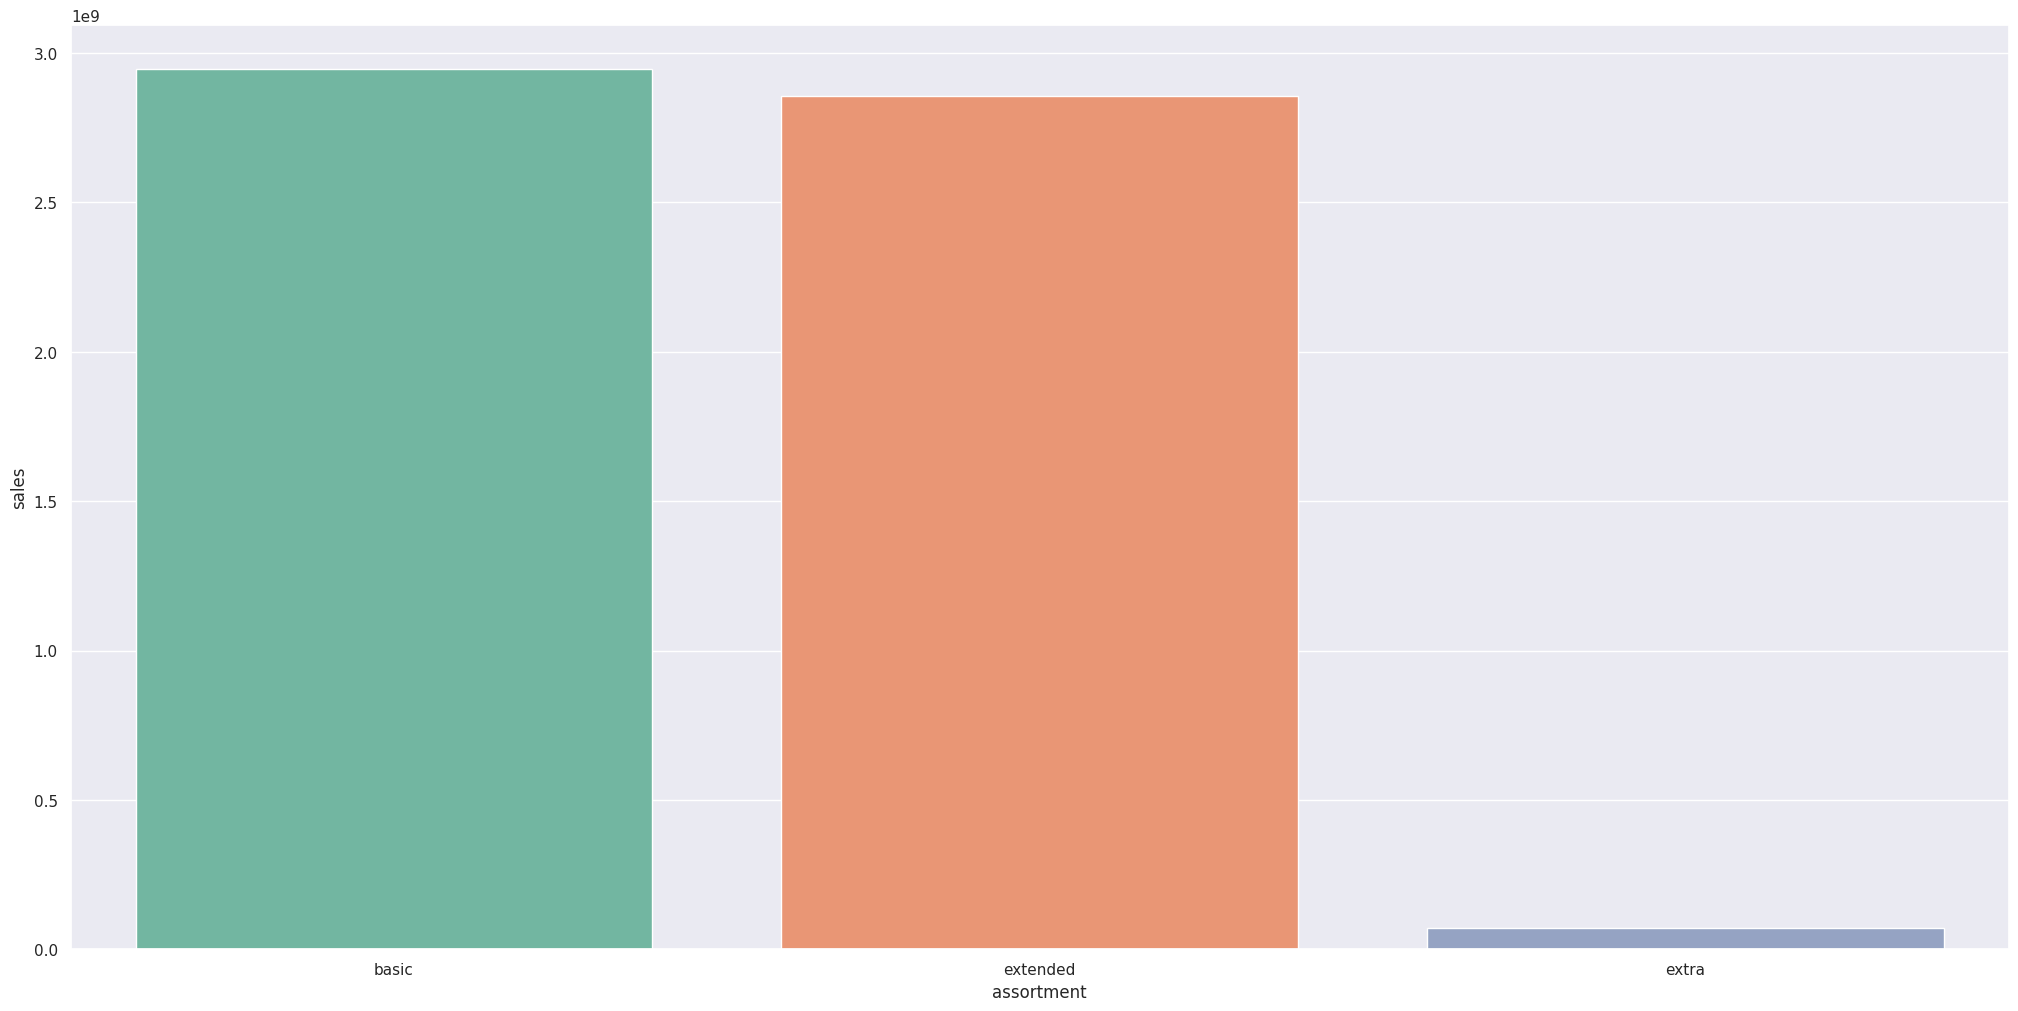

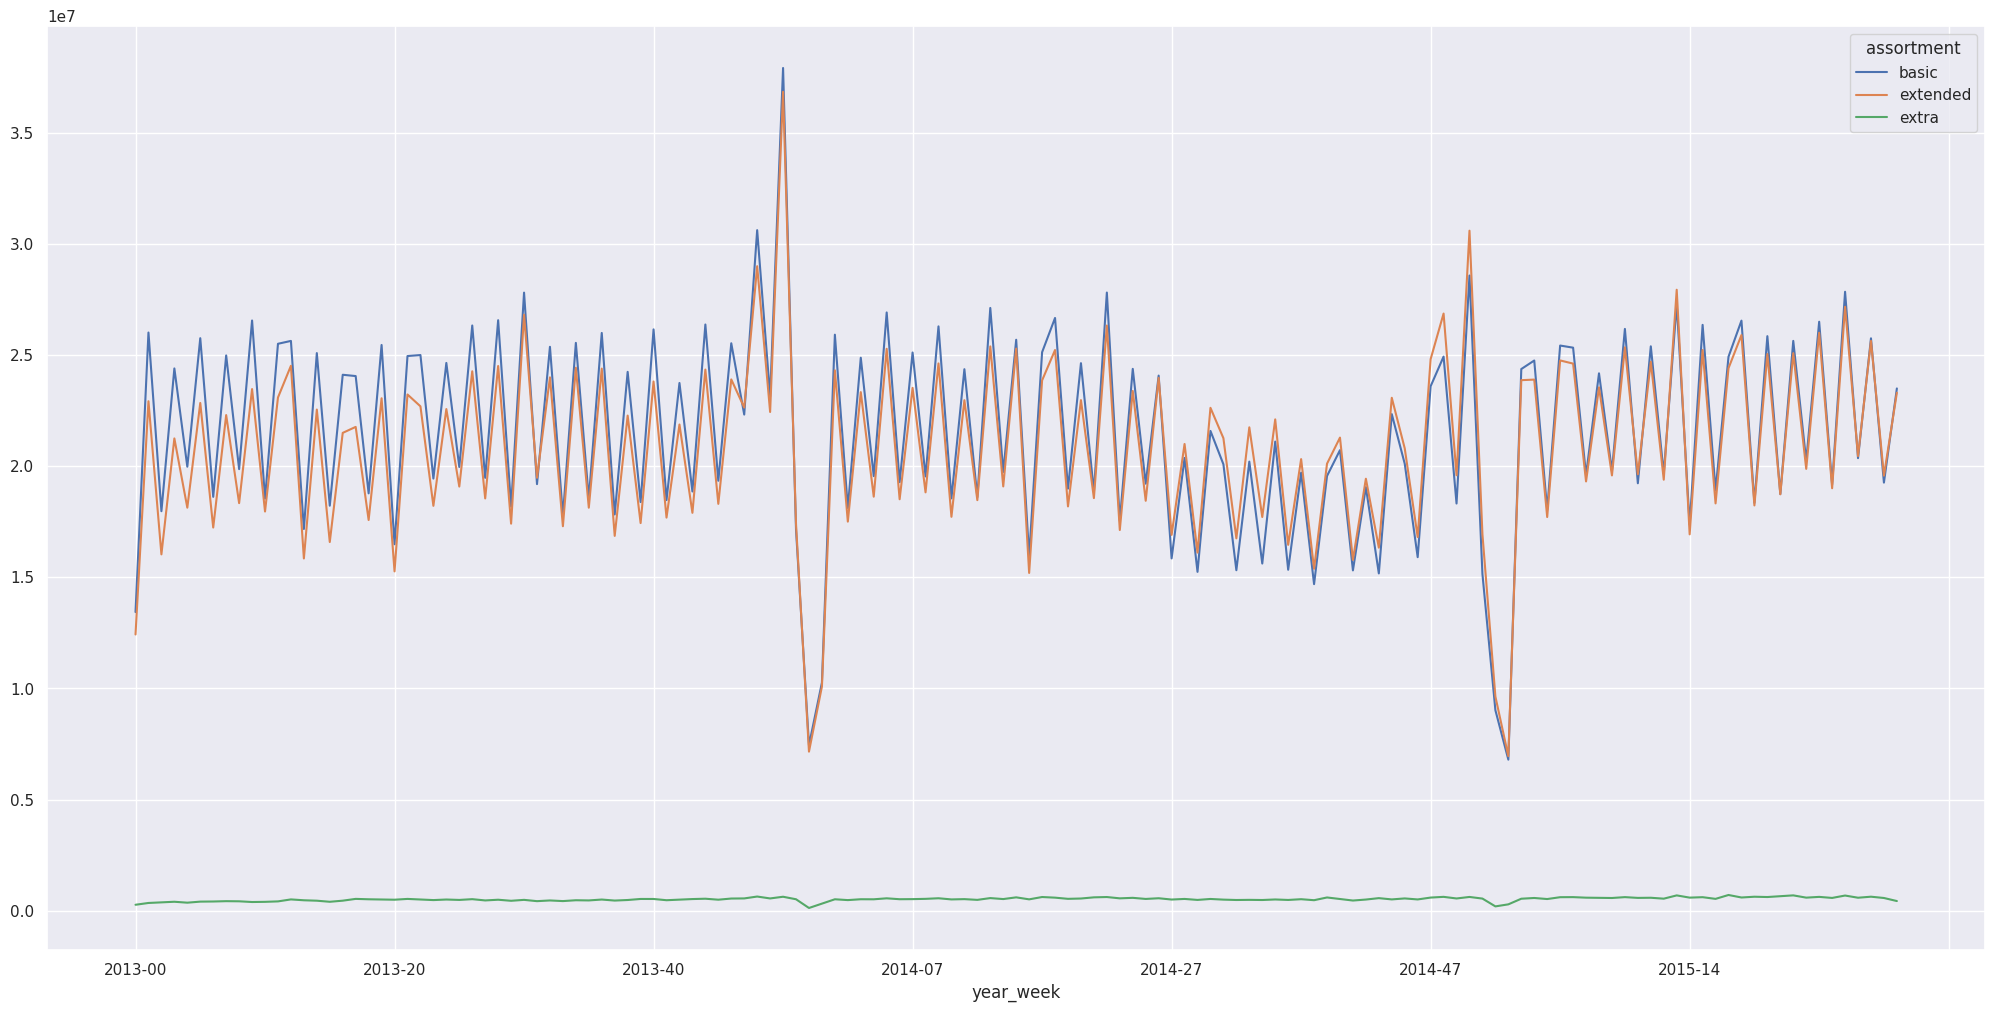

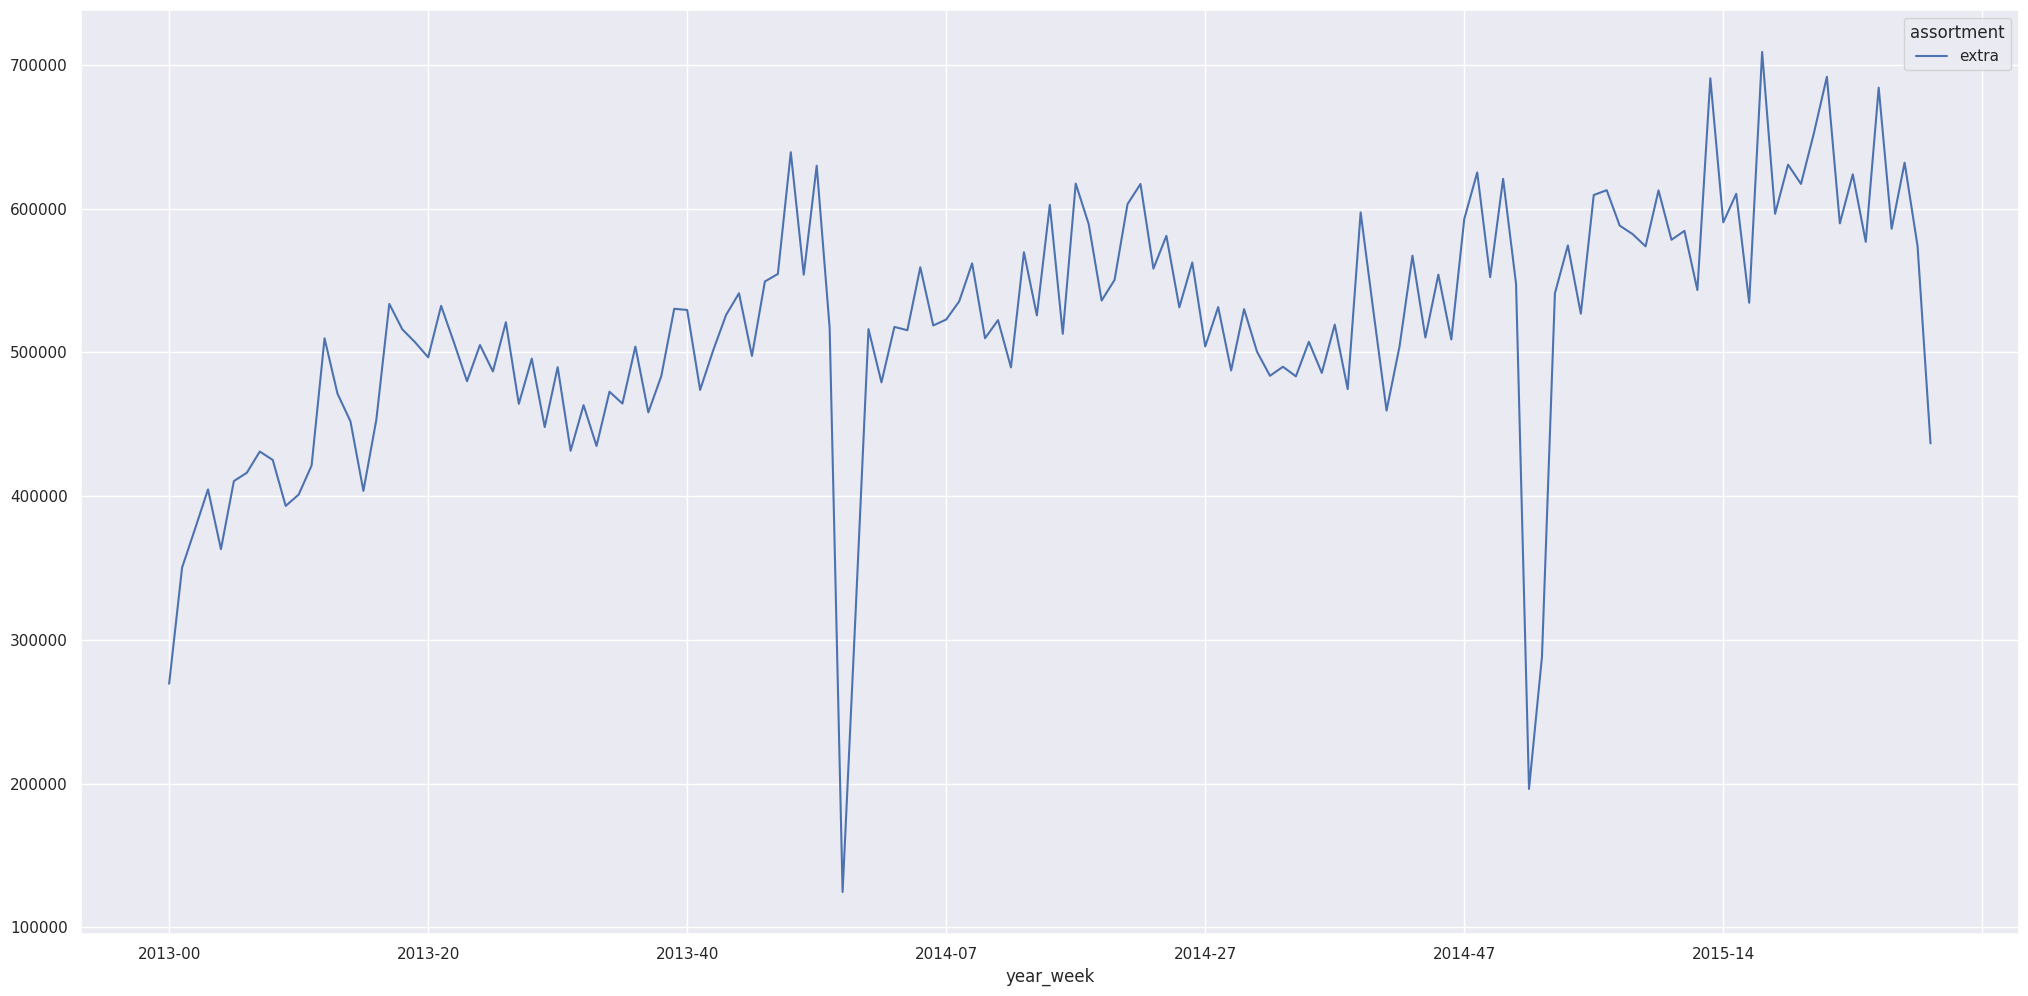

In [53]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y= 'sales', data=aux1, palette = palette);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux3 = aux2.pivot(index = 'year_week', columns = 'assortment', values= 'sales')
aux3.plot();

aux4 = aux2[aux2['assortment'] == 'extra']
aux5 = aux4.pivot(index = 'year_week', columns = 'assortment', values= 'sales')
aux5.plot();


### H2 - Lojas com competidores mais próximos deveriam vender menos
* Falsa. Lojas com competidores MAIS PRÓXIMOS vendem MAIS.

<ipython-input-54-dbf9ae57f3fc>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
<ipython-input-54-dbf9ae57f3fc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2, palette = palette);
<ipython-input-54-dbf9ae57f3fc>:13: UserWarning: 
The palette list has fewer values (8) than needed (19) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2, palette = palette);


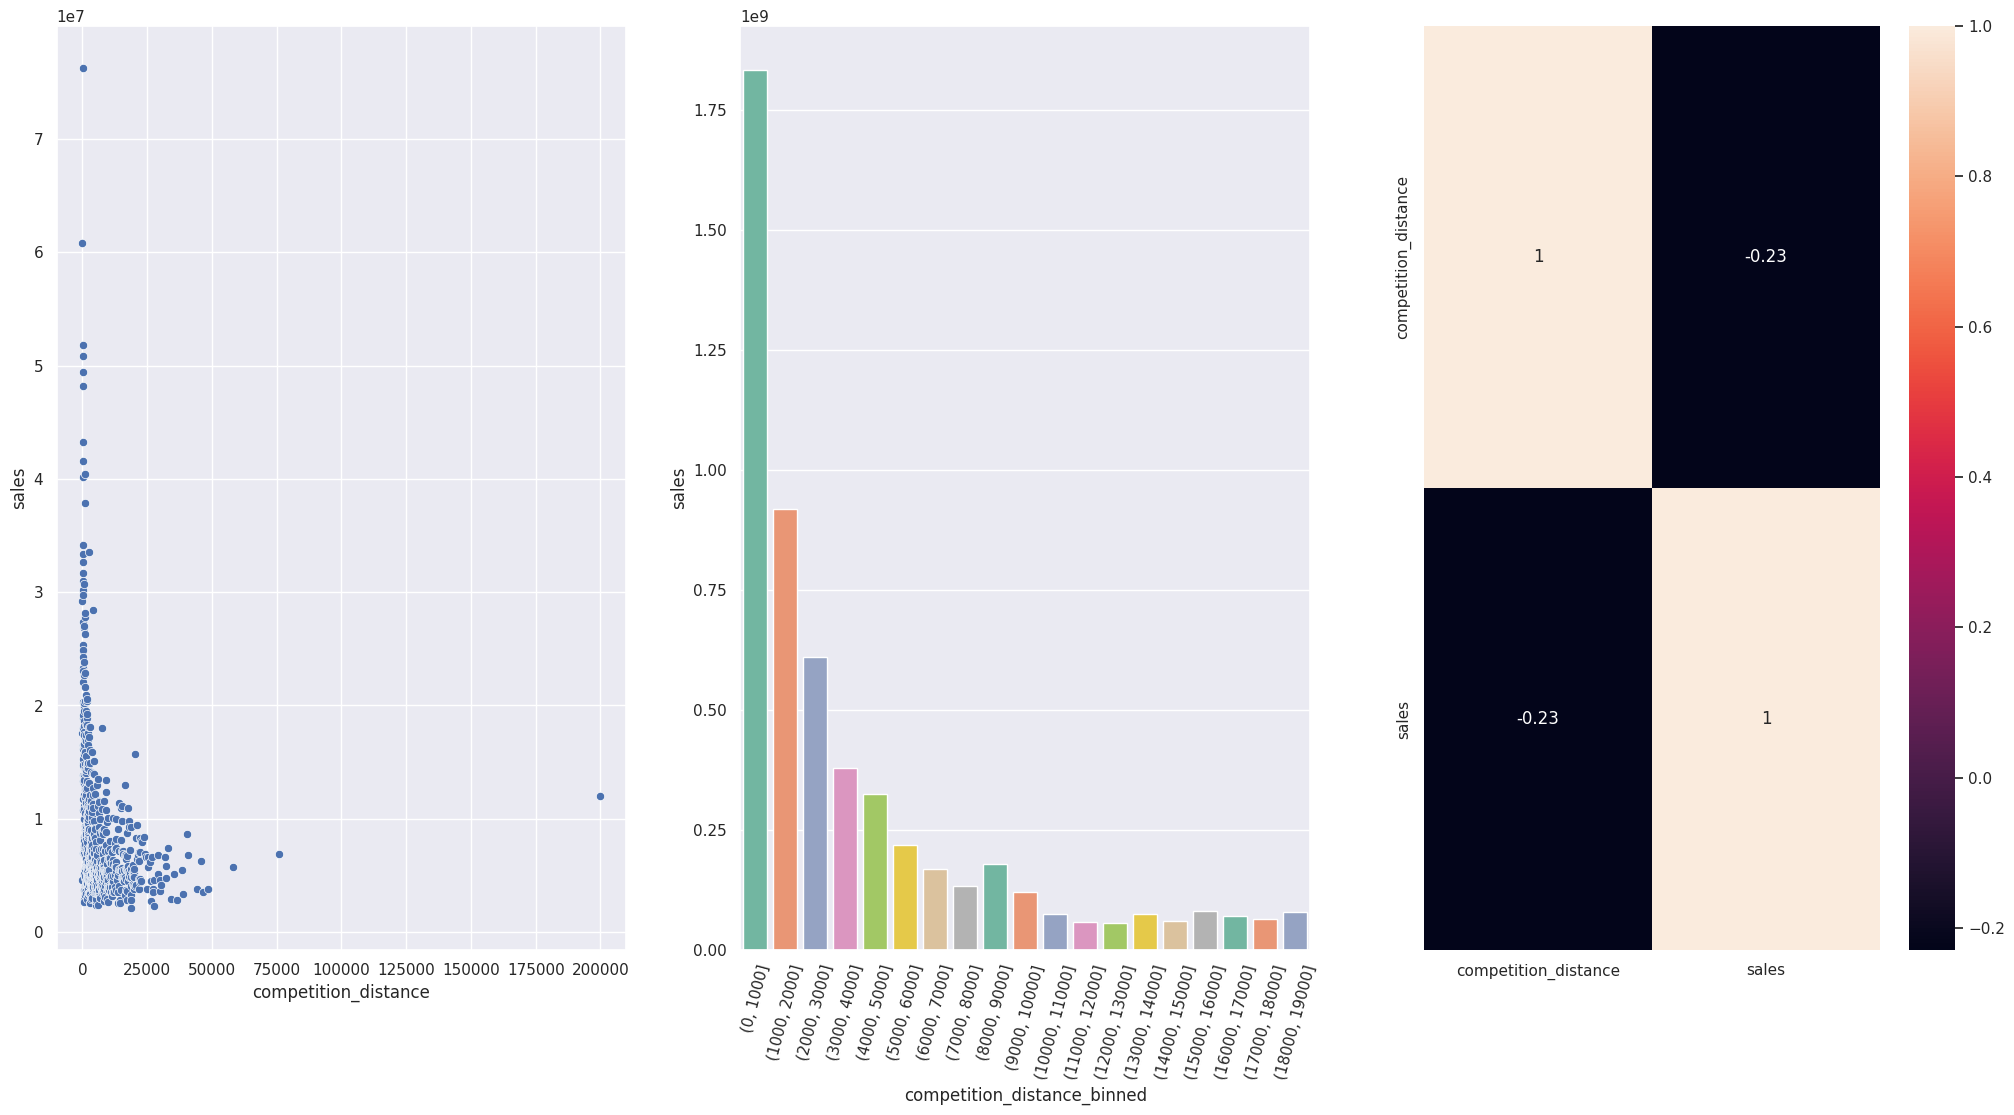

In [54]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y = 'sales',data = aux1)

plt.subplot(1,3,2)
#aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0,20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2, palette = palette);
plt.xticks(rotation = 75);

plt.subplot(1,3,3)
sns.heatmap(aux1[['competition_distance', 'sales']].corr(method = 'pearson'), annot = True);

<Axes: xlabel='competition_distance', ylabel='sales'>

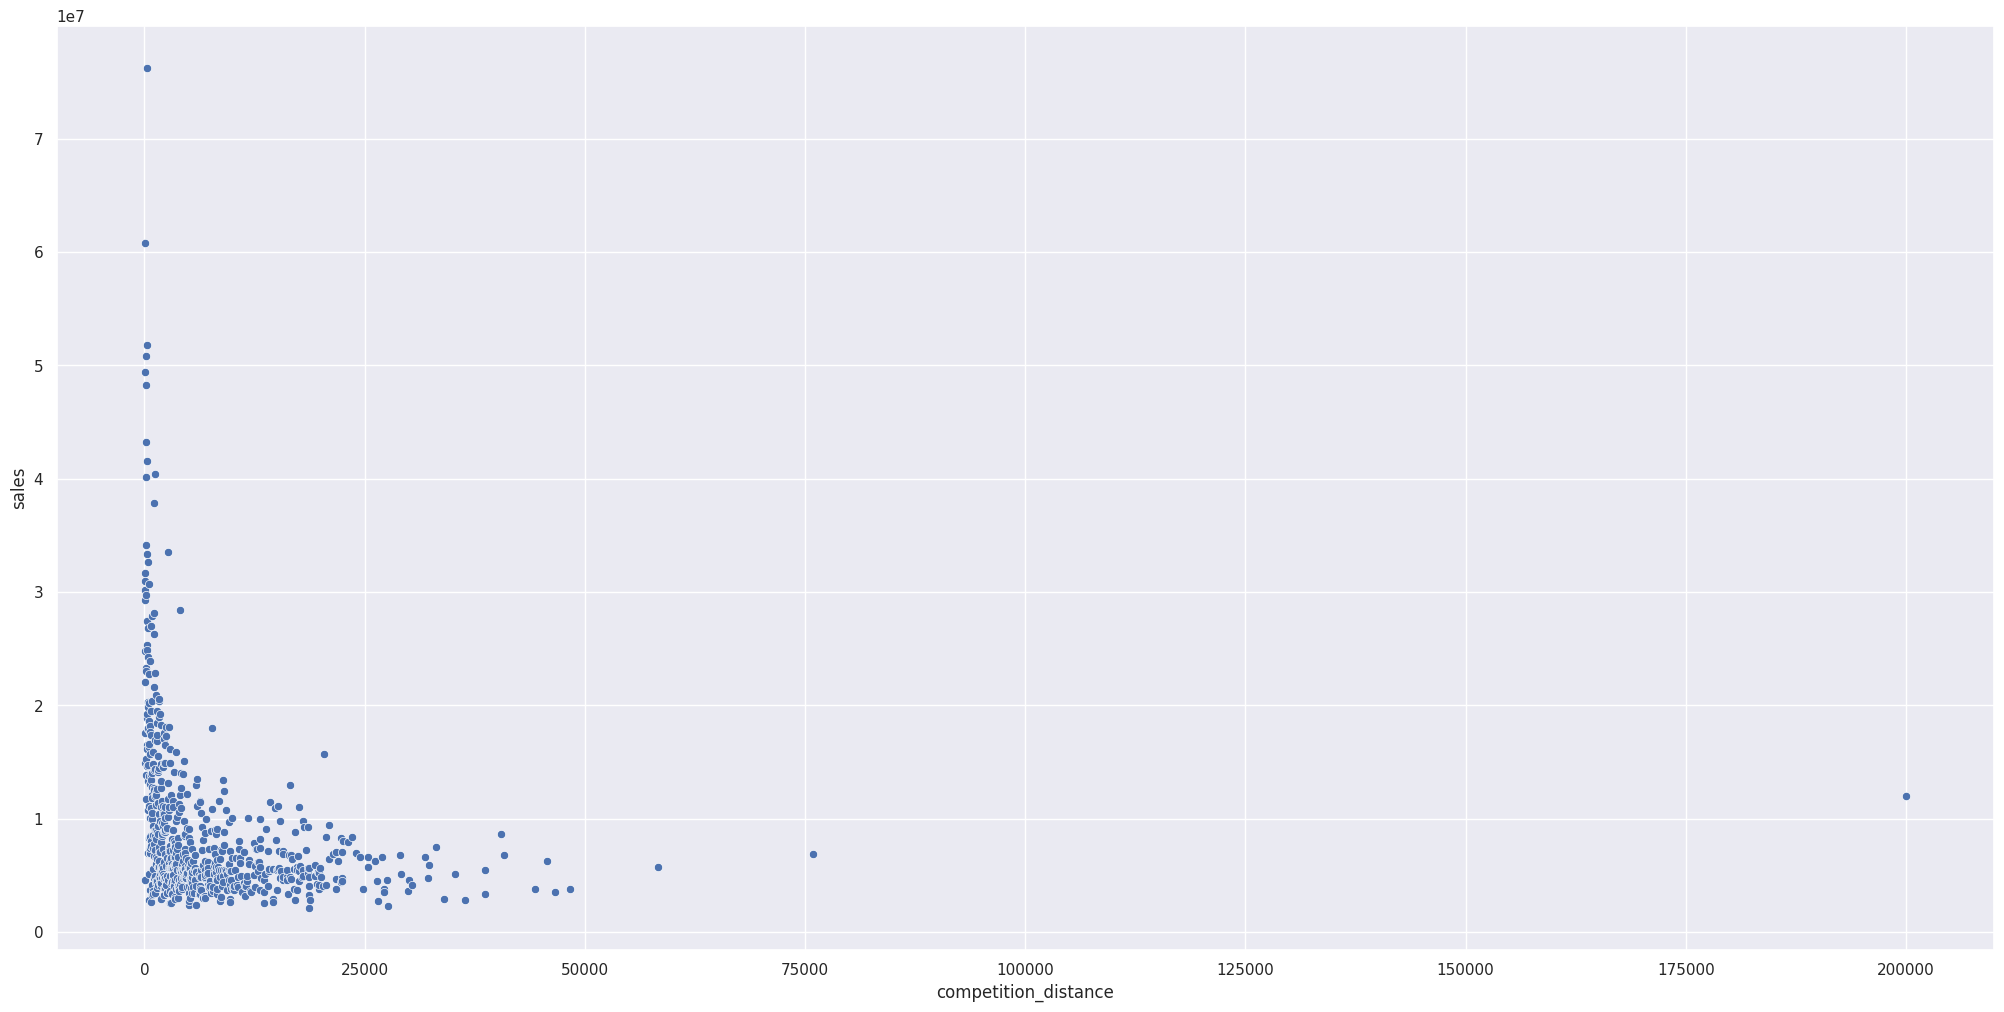

In [55]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x = 'competition_distance', y = 'sales',data = aux1)

### H3. Lojas com competidores abertos há mais tempo vendem mais.
* Falsa. Lojas com competidores há mais tempo vendem menos

<ipython-input-56-abba997bbd42>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= 'competition_time_month', y= 'sales', data= aux2, palette = palette);
<ipython-input-56-abba997bbd42>:4: UserWarning: 
The palette list has fewer values (8) than needed (150) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x= 'competition_time_month', y= 'sales', data= aux2, palette = palette);


(2.5, -0.5)

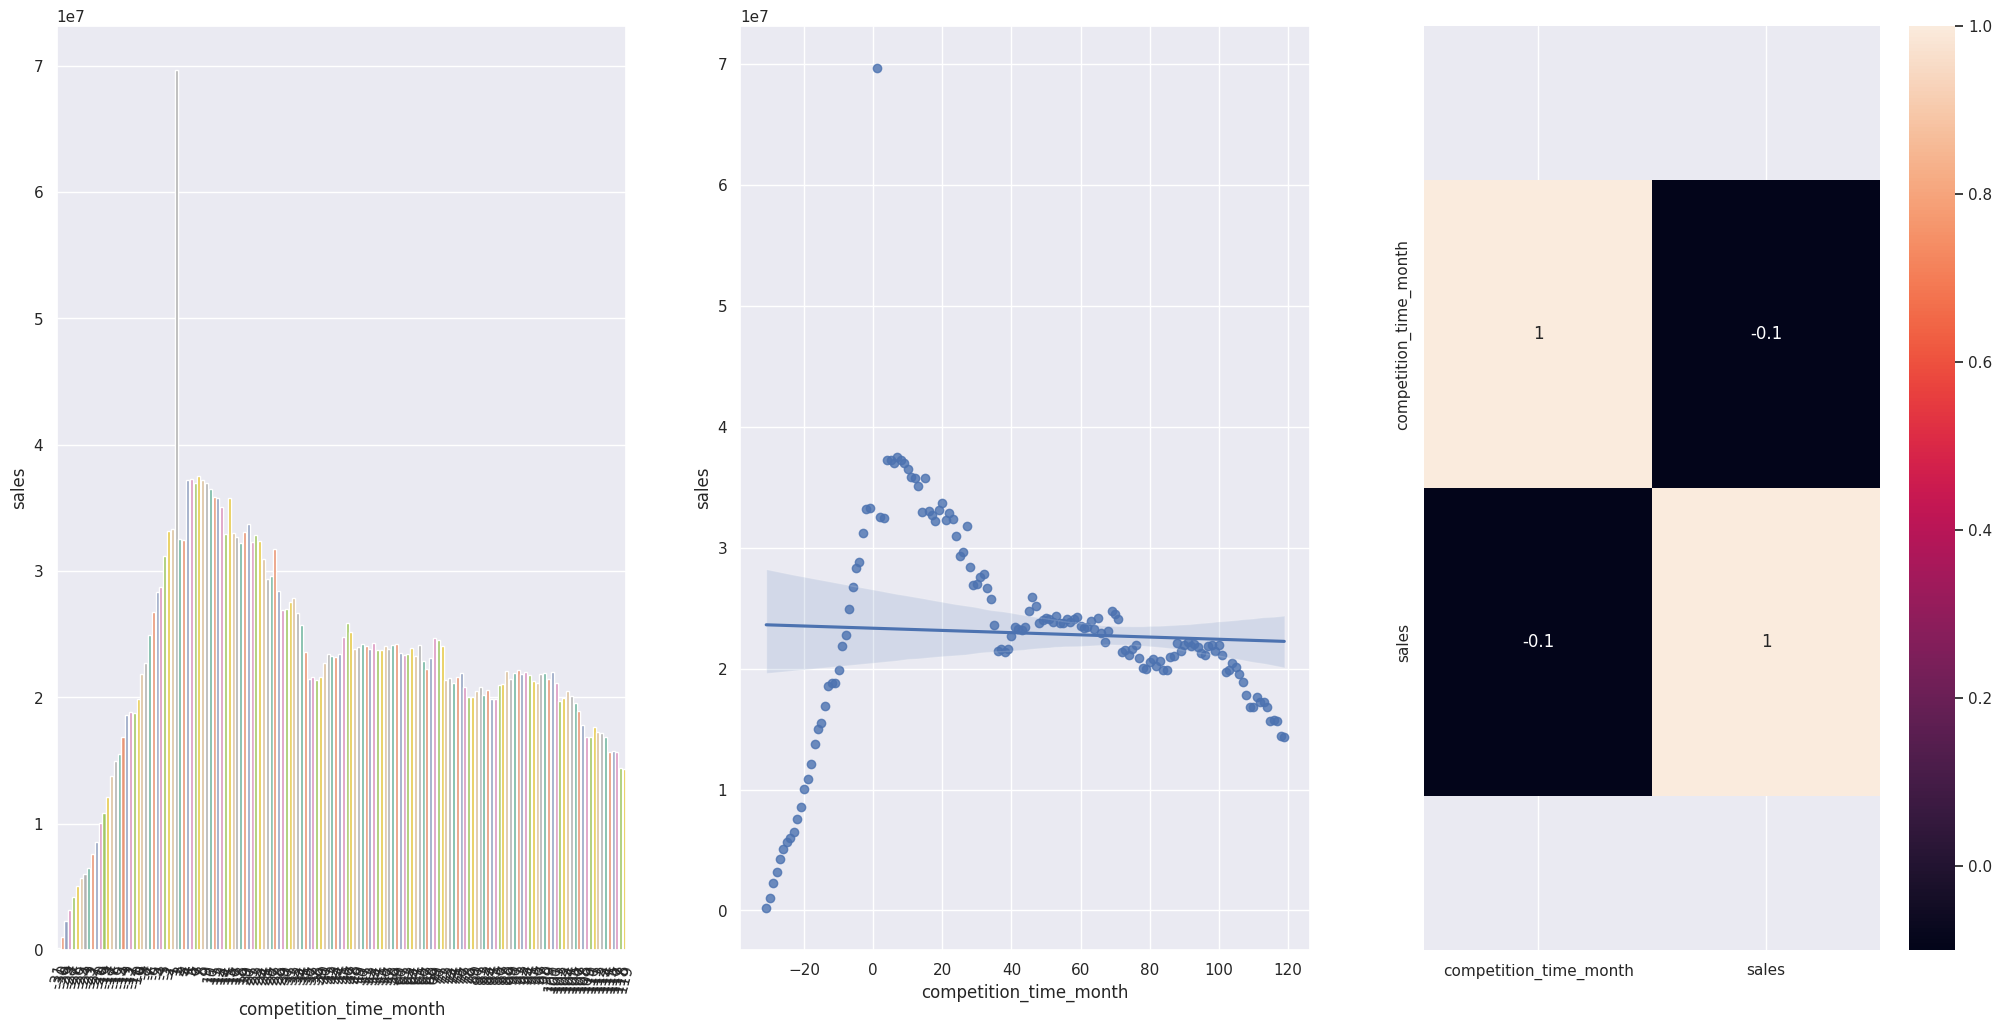

In [56]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2=aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
plt.subplot(1,3,1)
sns.barplot(x= 'competition_time_month', y= 'sales', data= aux2, palette = palette);
plt.xticks(rotation = 75);
plt.subplot(1,3,2)
sns.regplot(x= 'competition_time_month', y= 'sales', data= aux2);
plt.subplot(1,3,3)
x= sns.heatmap(aux1.corr(method='pearson'), annot= True);
bottom, top = x.get_ylim()
x.set_ylim(bottom + 0.5, top-0.5)


### H4. Lojas com promoções ativas há mais tempo deveriam vender mais
* Falsa. Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção.

<ipython-input-57-9803a1868bb3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= 'promo_time_week', y= 'sales', data= aux2, palette = palette);
<ipython-input-57-9803a1868bb3>:6: UserWarning: 
The palette list has fewer values (8) than needed (313) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x= 'promo_time_week', y= 'sales', data= aux2, palette = palette);
<ipython-input-57-9803a1868bb3>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= 'promo_time_week', y= 'sales', data= aux3, palette = palette);
<ipython-input-57-9803a1868bb3>:14: UserWarning: 
The palette list has fewer values (8) than needed (126) and will cycle, which may produce an uninterpretable 

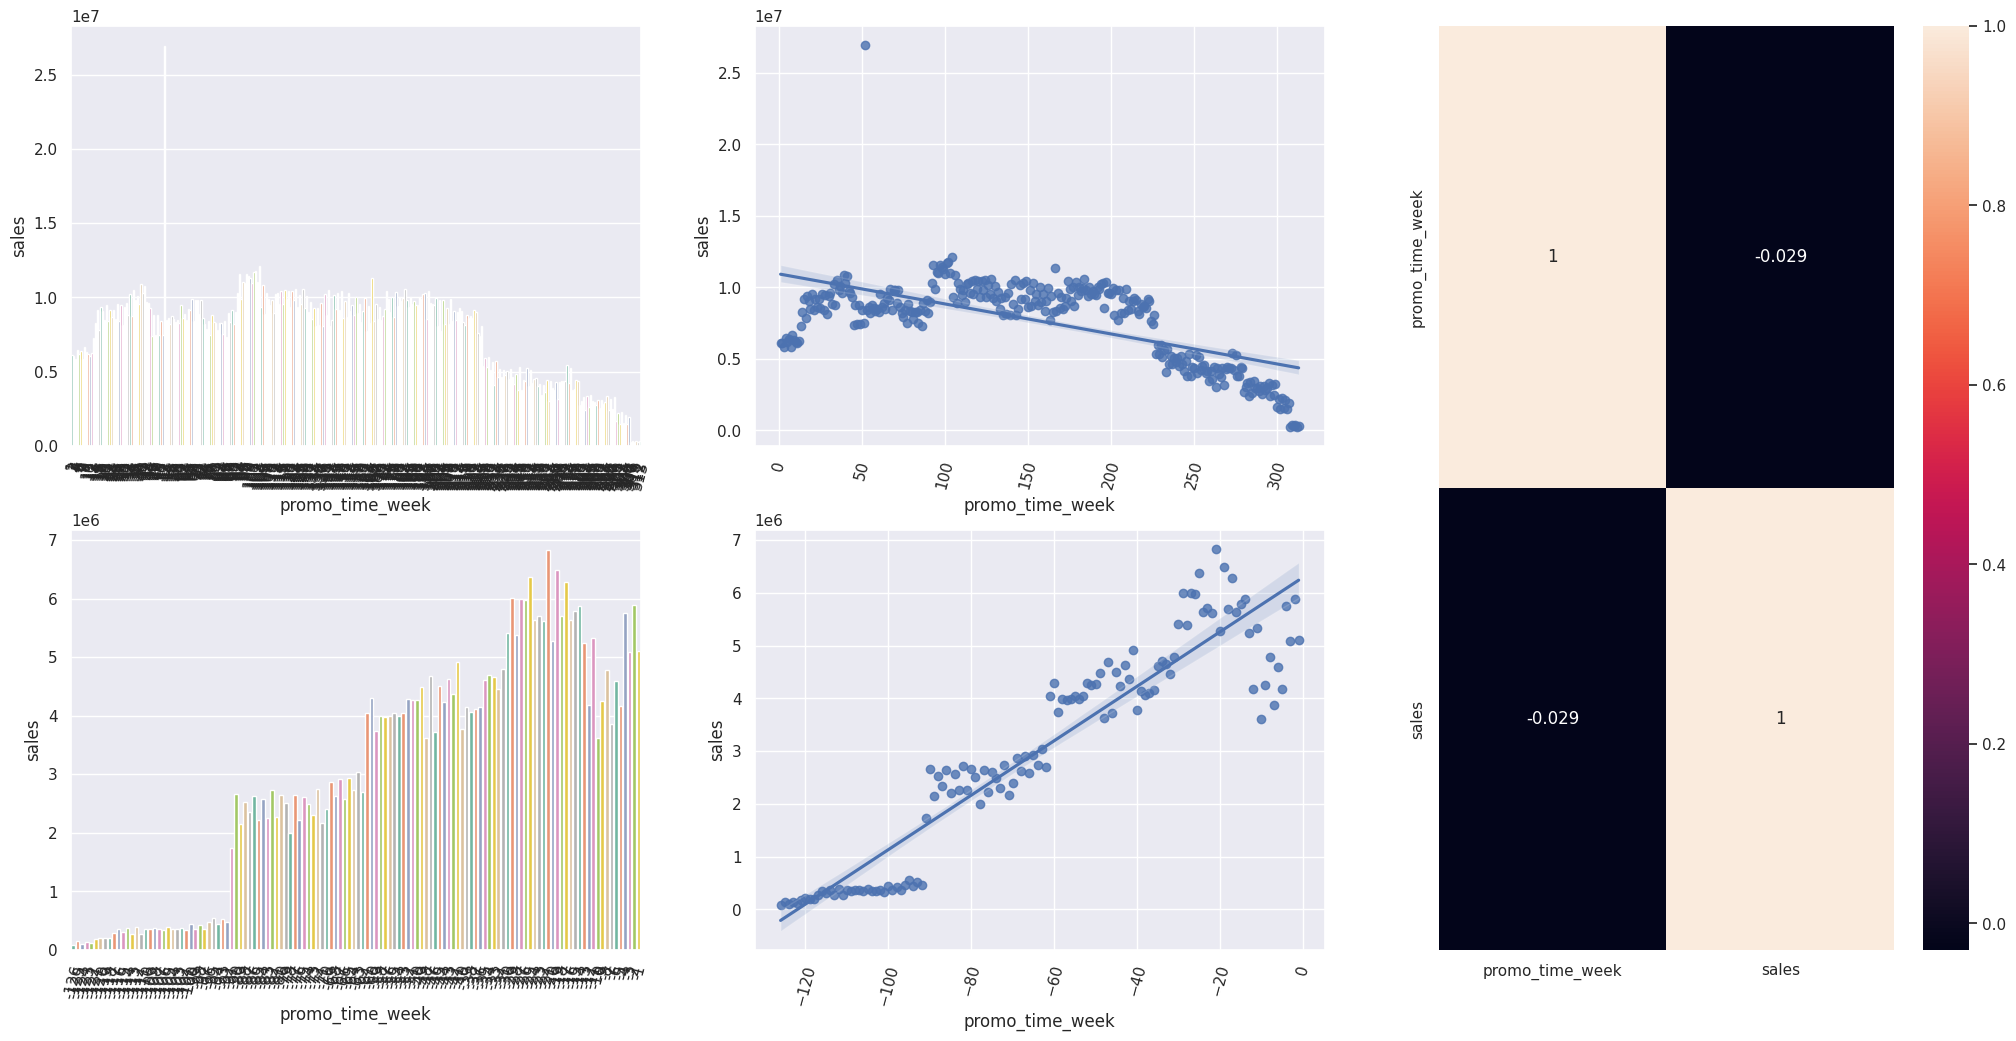

In [57]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendida
sns.barplot(x= 'promo_time_week', y= 'sales', data= aux2, palette = palette);
plt.xticks(rotation = 75);
plt.subplot(grid[0,1])
sns.regplot(x= 'promo_time_week', y= 'sales', data= aux2);
plt.xticks(rotation = 75);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x= 'promo_time_week', y= 'sales', data= aux3, palette = palette);
plt.xticks(rotation = 75);
plt.subplot(grid[1,1])
sns.regplot(x= 'promo_time_week', y= 'sales', data= aux3);
plt.xticks(rotation = 75);
plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method= 'pearson'),annot=True);

### <s> H5. Lojas com mais dias de promoção deveriam vender mais.</s>


### H7. Lojas com mais promoções consecutivas deveriam vender mais.
* Falsa. Lojas com 2 promoções ativas vendem menos

In [58]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


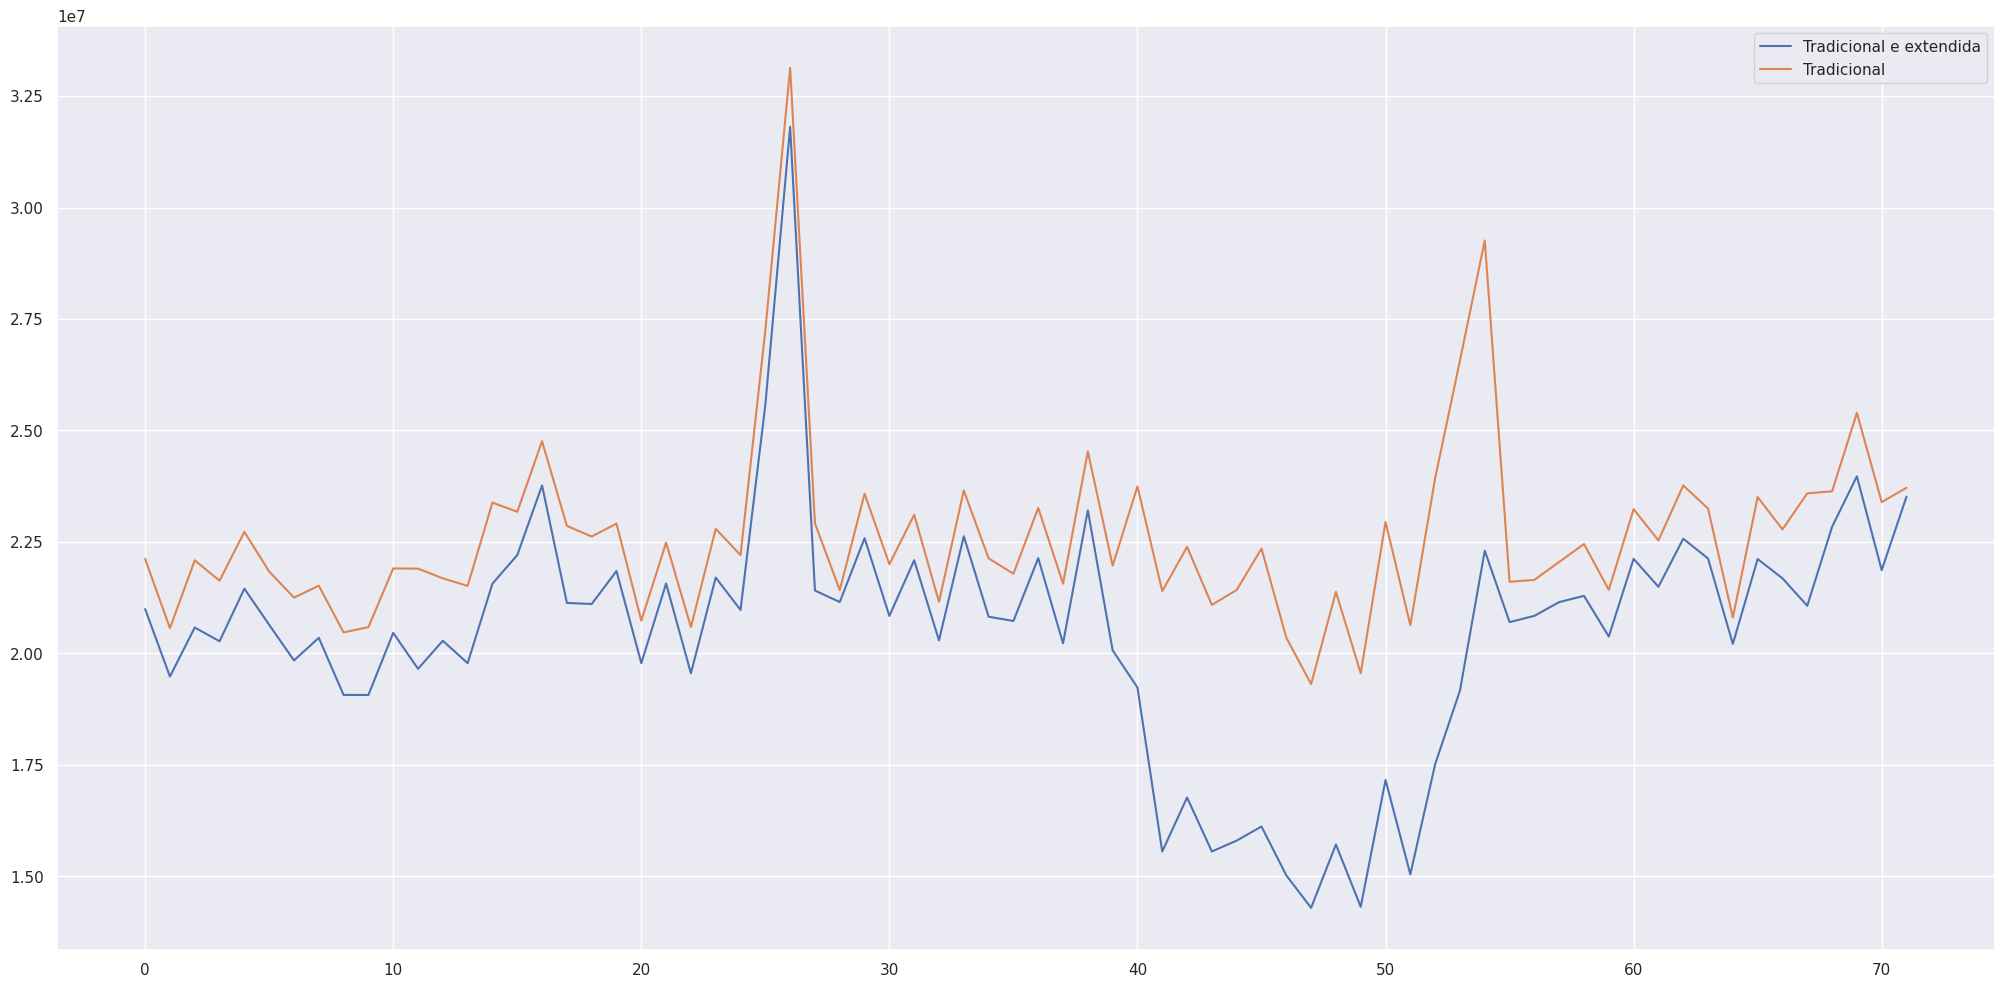

In [59]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)
ax.legend(labels = ['Tradicional e extendida', 'Tradicional'])

### H8. Lojas abertas durante o feriado de Natal deveriam vender mais.
* Falsa. No Natal as lojas vendem menos em relação a outros feriados.


<ipython-input-60-0f3ab812c3f7>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= 'state_holiday', y= 'sales', data= aux1, palette = palette);
<ipython-input-60-0f3ab812c3f7>:4: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(x= 'state_holiday', y= 'sales', data= aux1, palette = palette);
<ipython-input-60-0f3ab812c3f7>:7: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(x= 'year', y= 'sales', data= aux2, hue= 'state_holiday', palette = palette);


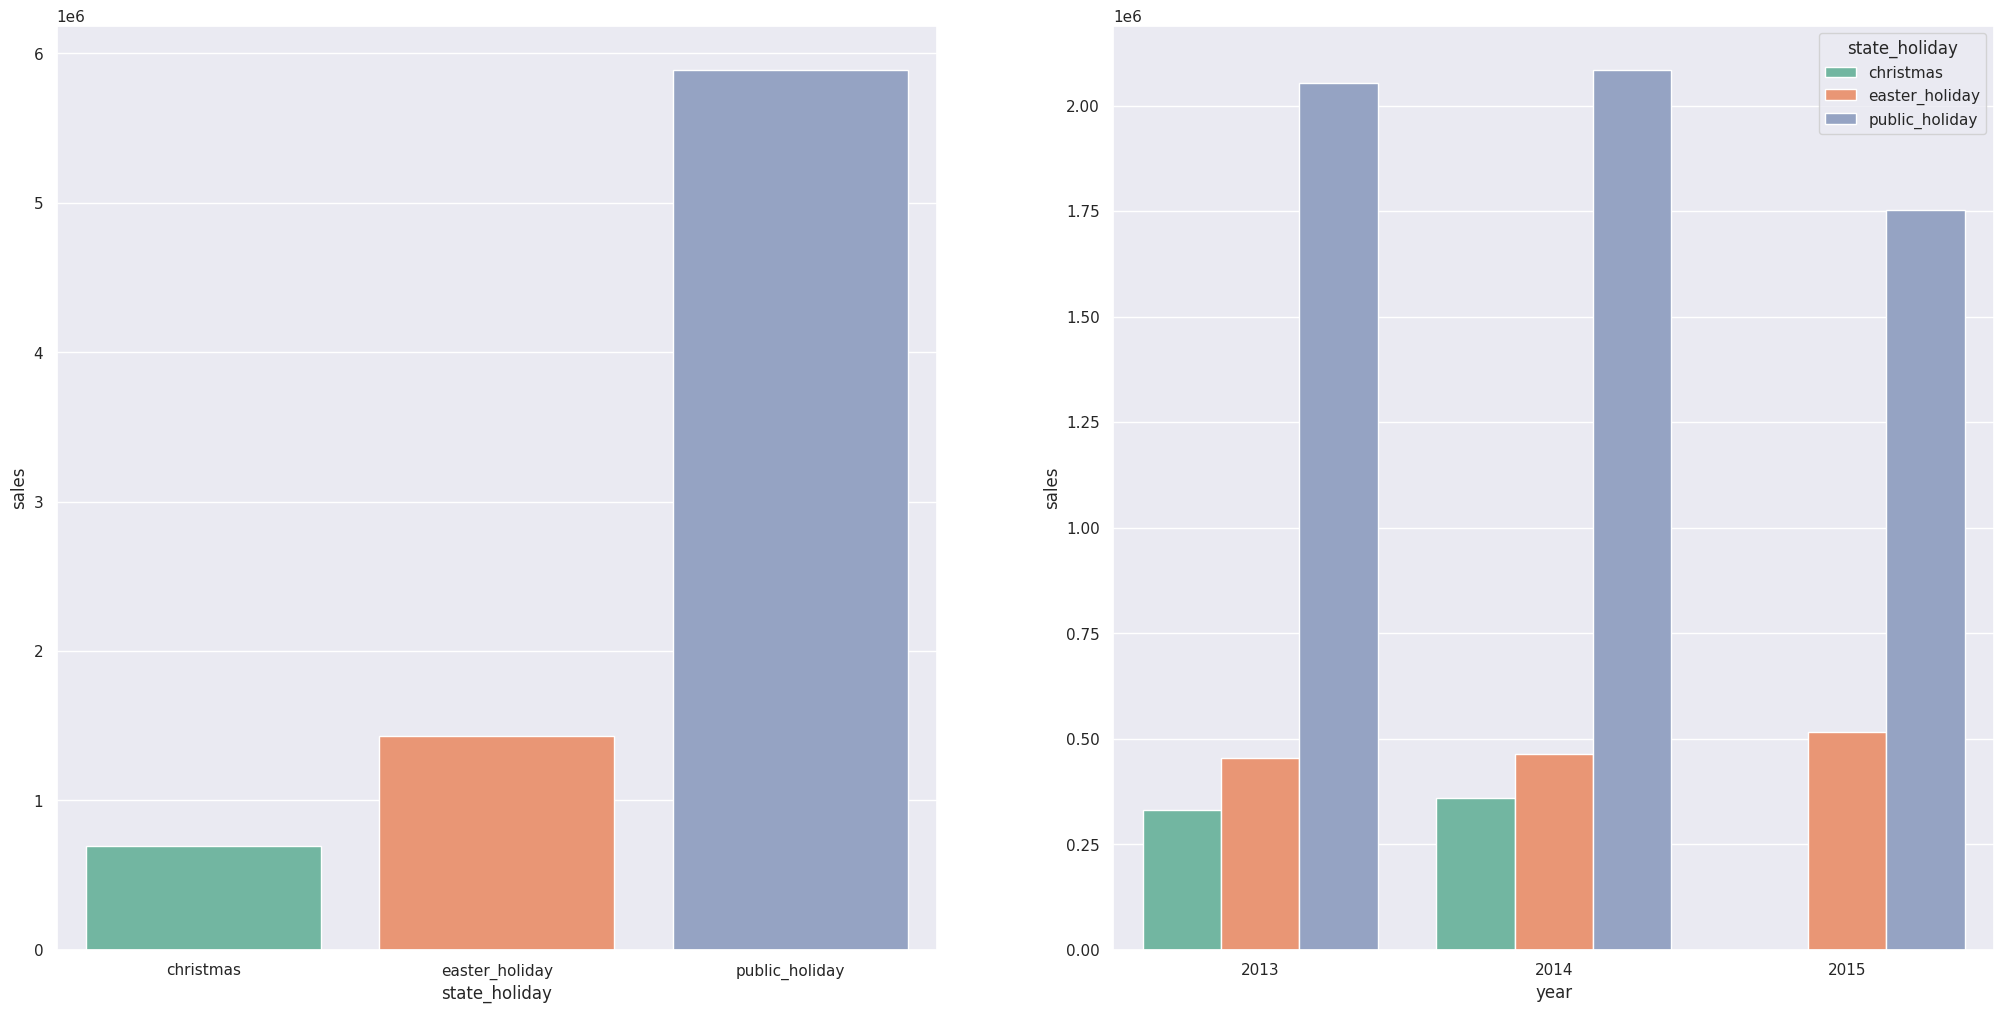

In [60]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x= 'state_holiday', y= 'sales', data= aux1, palette = palette);
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
plt.subplot(1,2,2)
sns.barplot(x= 'year', y= 'sales', data= aux2, hue= 'state_holiday', palette = palette);

### H9. Lojas deveriam vender mais ao longo dos anos
* Falsa. Lojas vendem menos ao longo dos anos.

<ipython-input-61-551e3a7e3614>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= 'year', y= 'sales', data= aux1, palette=palette);
<ipython-input-61-551e3a7e3614>:3: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(x= 'year', y= 'sales', data= aux1, palette=palette);


<Axes: >

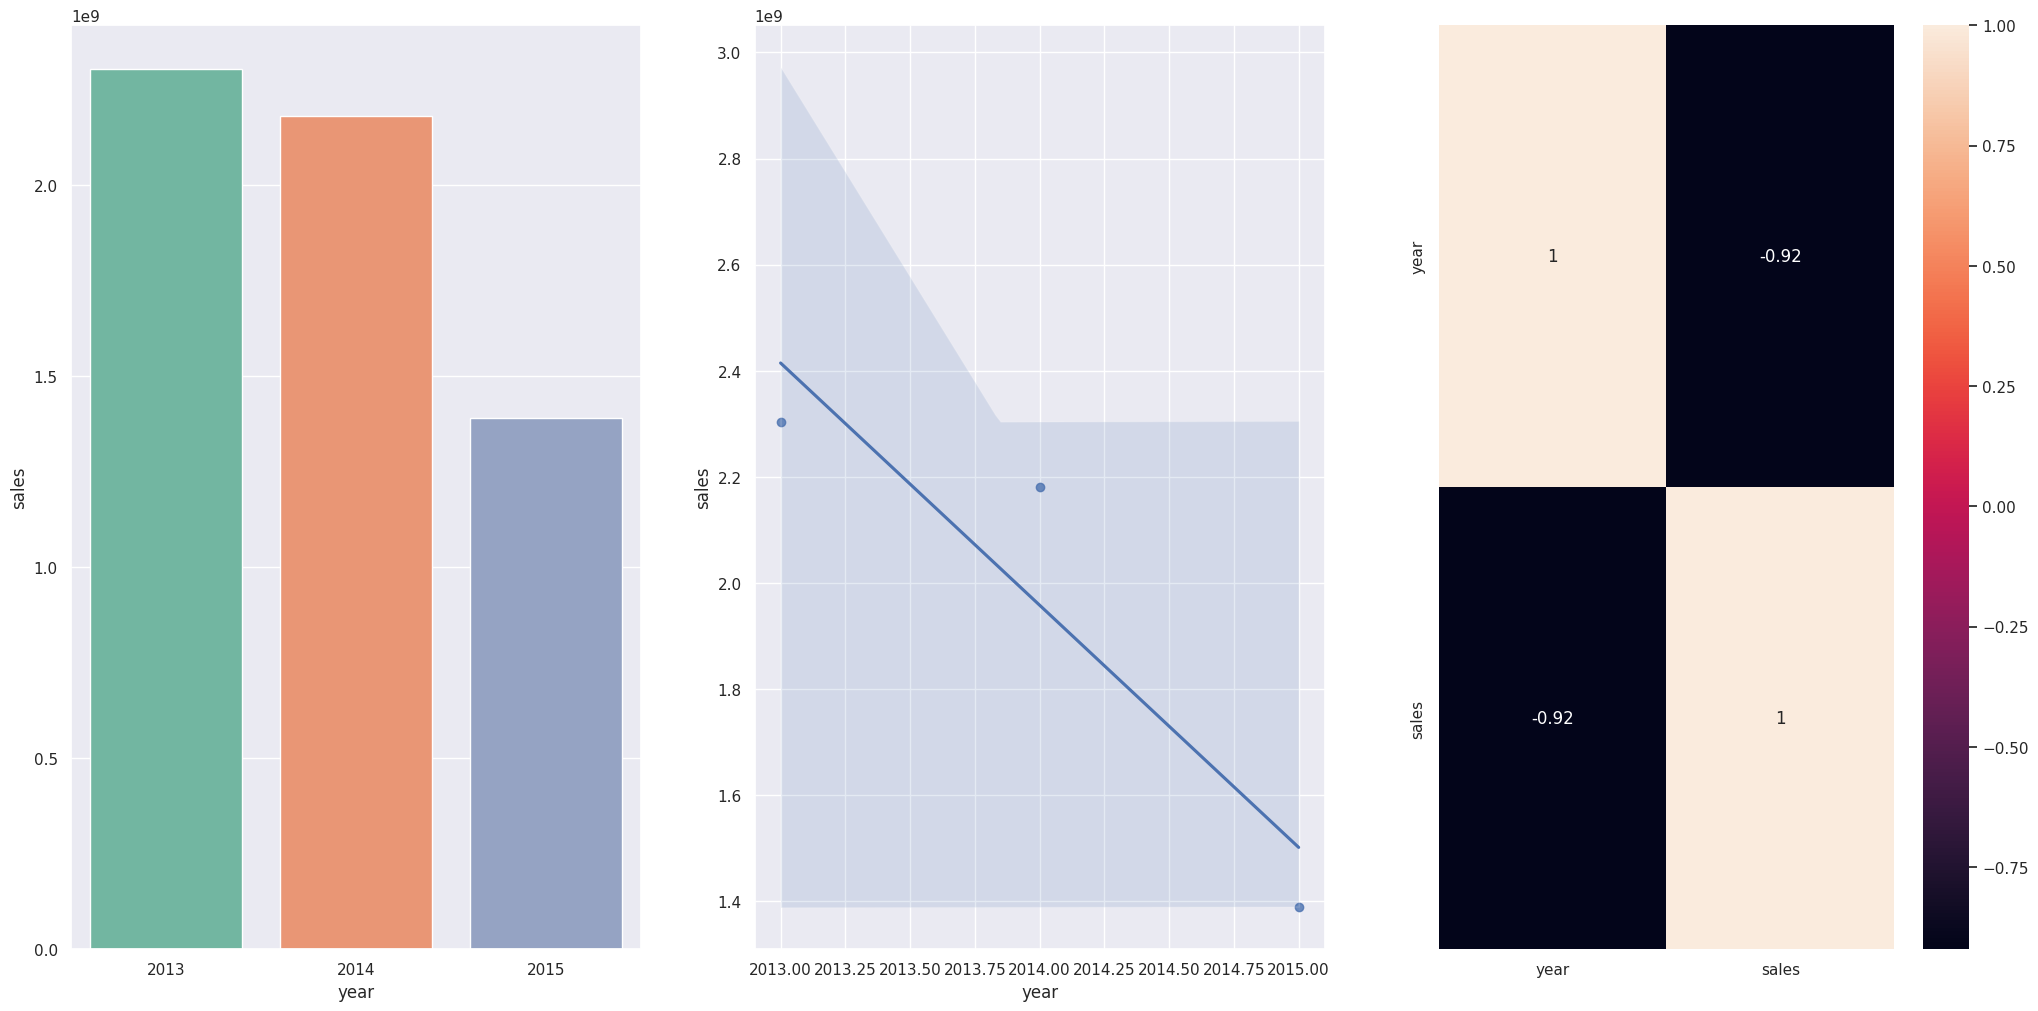

In [61]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x= 'year', y= 'sales', data= aux1, palette=palette);
plt.subplot(1,3,2)
sns.regplot(x= 'year', y= 'sales', data= aux1);
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True)

### H10. Lojas deveriam vender mais no segundo semestre do ano.
* Falsa. Lojas vendem menos no segundo semestre do ano.

<ipython-input-62-b46b8ac53f69>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= 'month', y= 'sales', data= aux1, palette=palette);
<ipython-input-62-b46b8ac53f69>:3: UserWarning: 
The palette list has fewer values (8) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x= 'month', y= 'sales', data= aux1, palette=palette);


<Axes: >

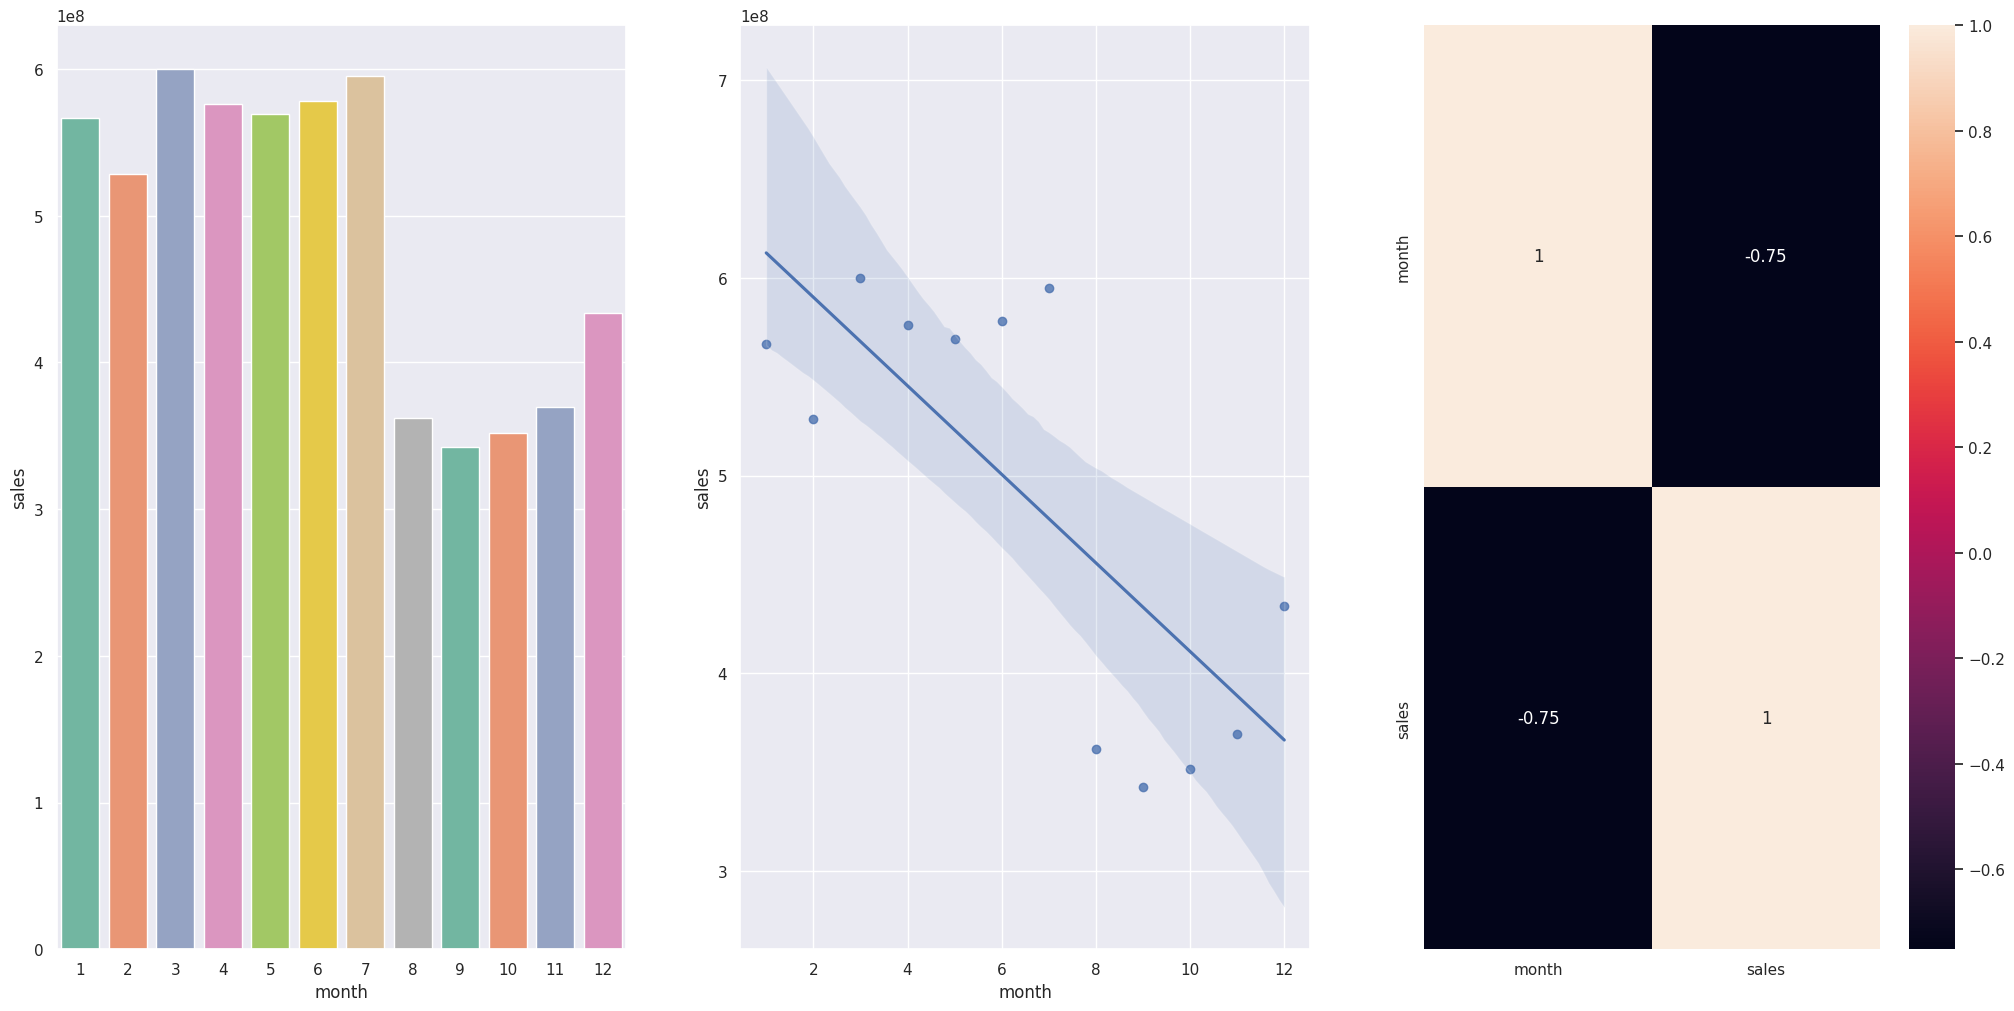

In [62]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x= 'month', y= 'sales', data= aux1, palette=palette);
plt.subplot(1,3,2)
sns.regplot(x= 'month', y= 'sales', data= aux1);
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True)

### H11. Lojas deveriam vender mais após o dia 10 de cada mês.
* Verdadeira. O volume de vendas é maior após o dia 10

<ipython-input-63-7841bec03c11>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= 'day', y= 'sales', data= aux1, palette=palette);
<ipython-input-63-7841bec03c11>:3: UserWarning: 
The palette list has fewer values (8) than needed (31) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x= 'day', y= 'sales', data= aux1, palette=palette);
<ipython-input-63-7841bec03c11>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= 'before_after', y= 'sales', data=aux2, palette=palette)
<ipython-input-63-7841bec03c11>:11: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.barplot(x= 'before_after', y= 'sales', data=aux2, palette=p

<Axes: xlabel='before_after', ylabel='sales'>

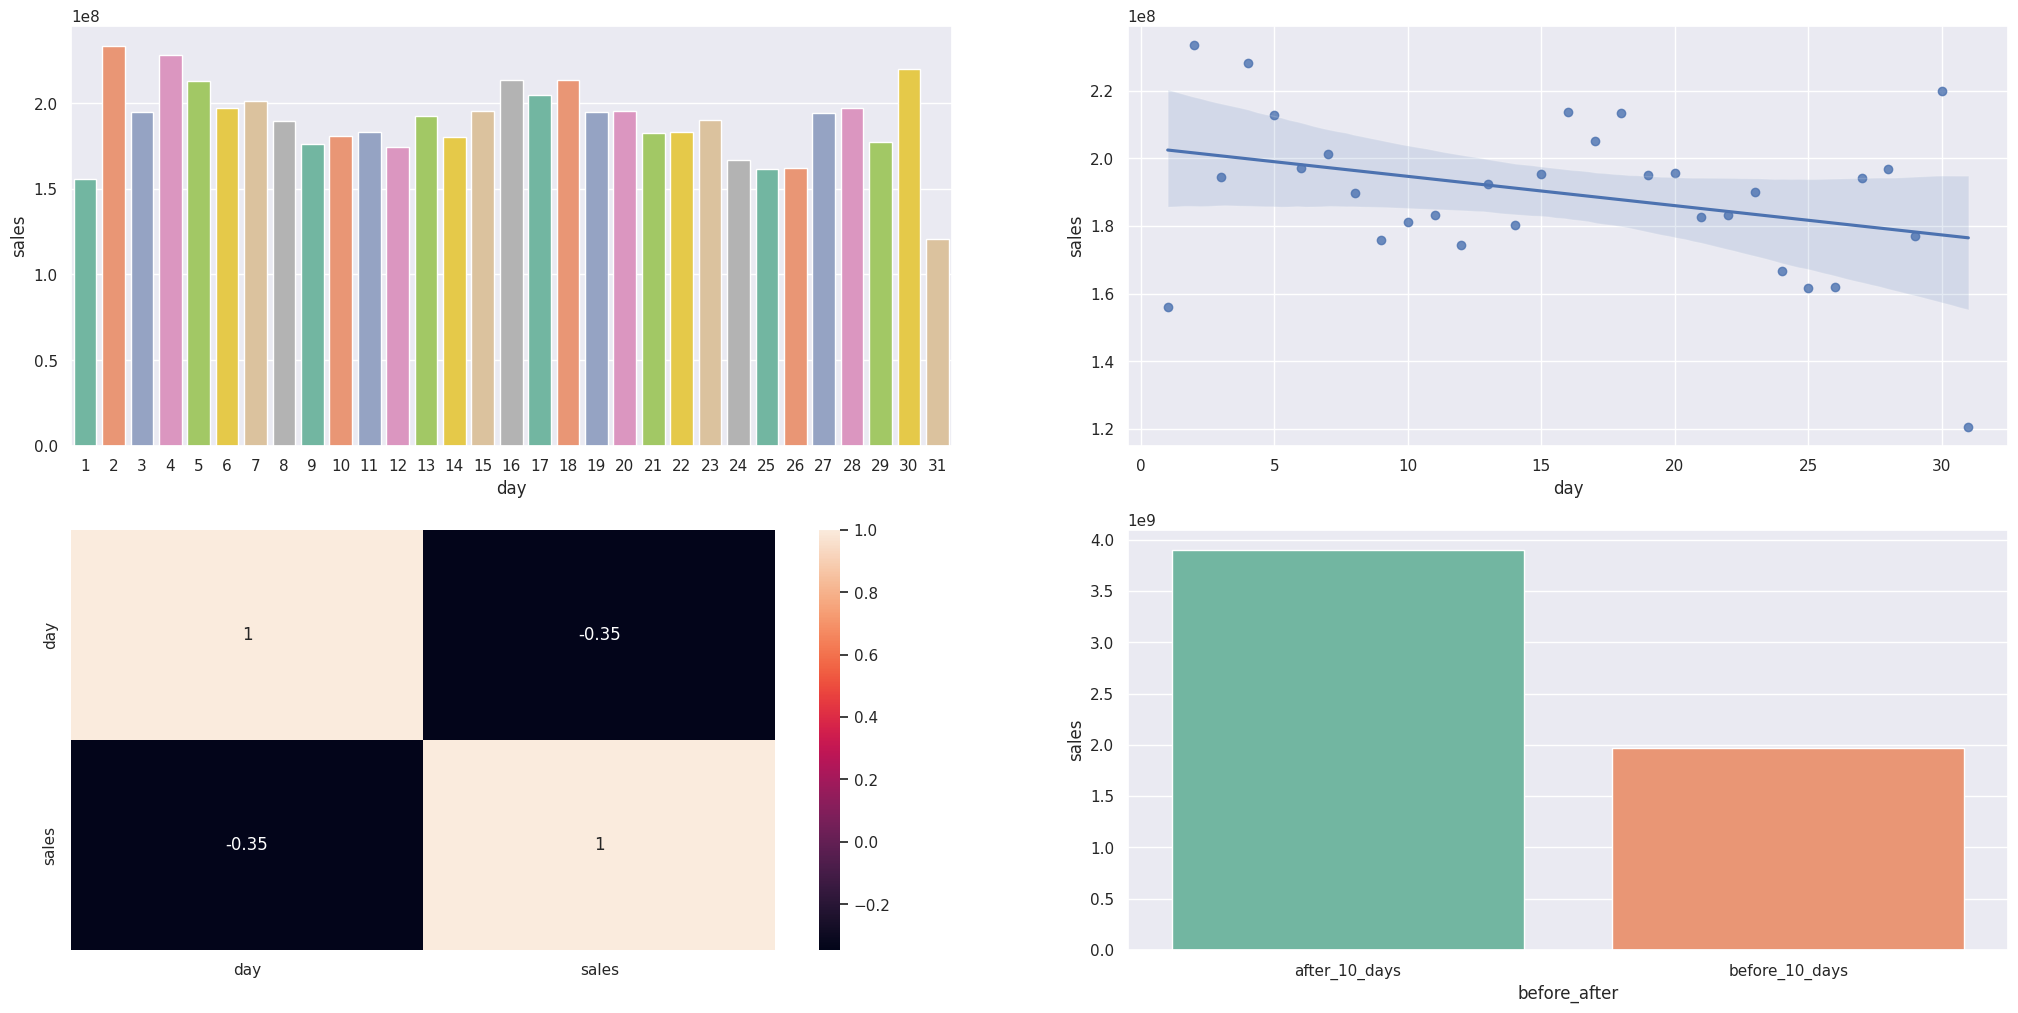

In [63]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
plt.subplot(2,2,1)
sns.barplot(x= 'day', y= 'sales', data= aux1, palette=palette);
plt.subplot(2,2,2)
sns.regplot(x= 'day', y= 'sales', data= aux1);
plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True)
plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x= 'before_after', y= 'sales', data=aux2, palette=palette)

### H12. Lojas deveriam vender menos aos finais de semana
* Verdadeira. Lojas vendem menos aos finais de semana.

<ipython-input-64-02164dd14c4e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= 'day_of_week', y= 'sales', data= aux1, palette=palette);
<ipython-input-64-02164dd14c4e>:3: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.barplot(x= 'day_of_week', y= 'sales', data= aux1, palette=palette);


<Axes: >

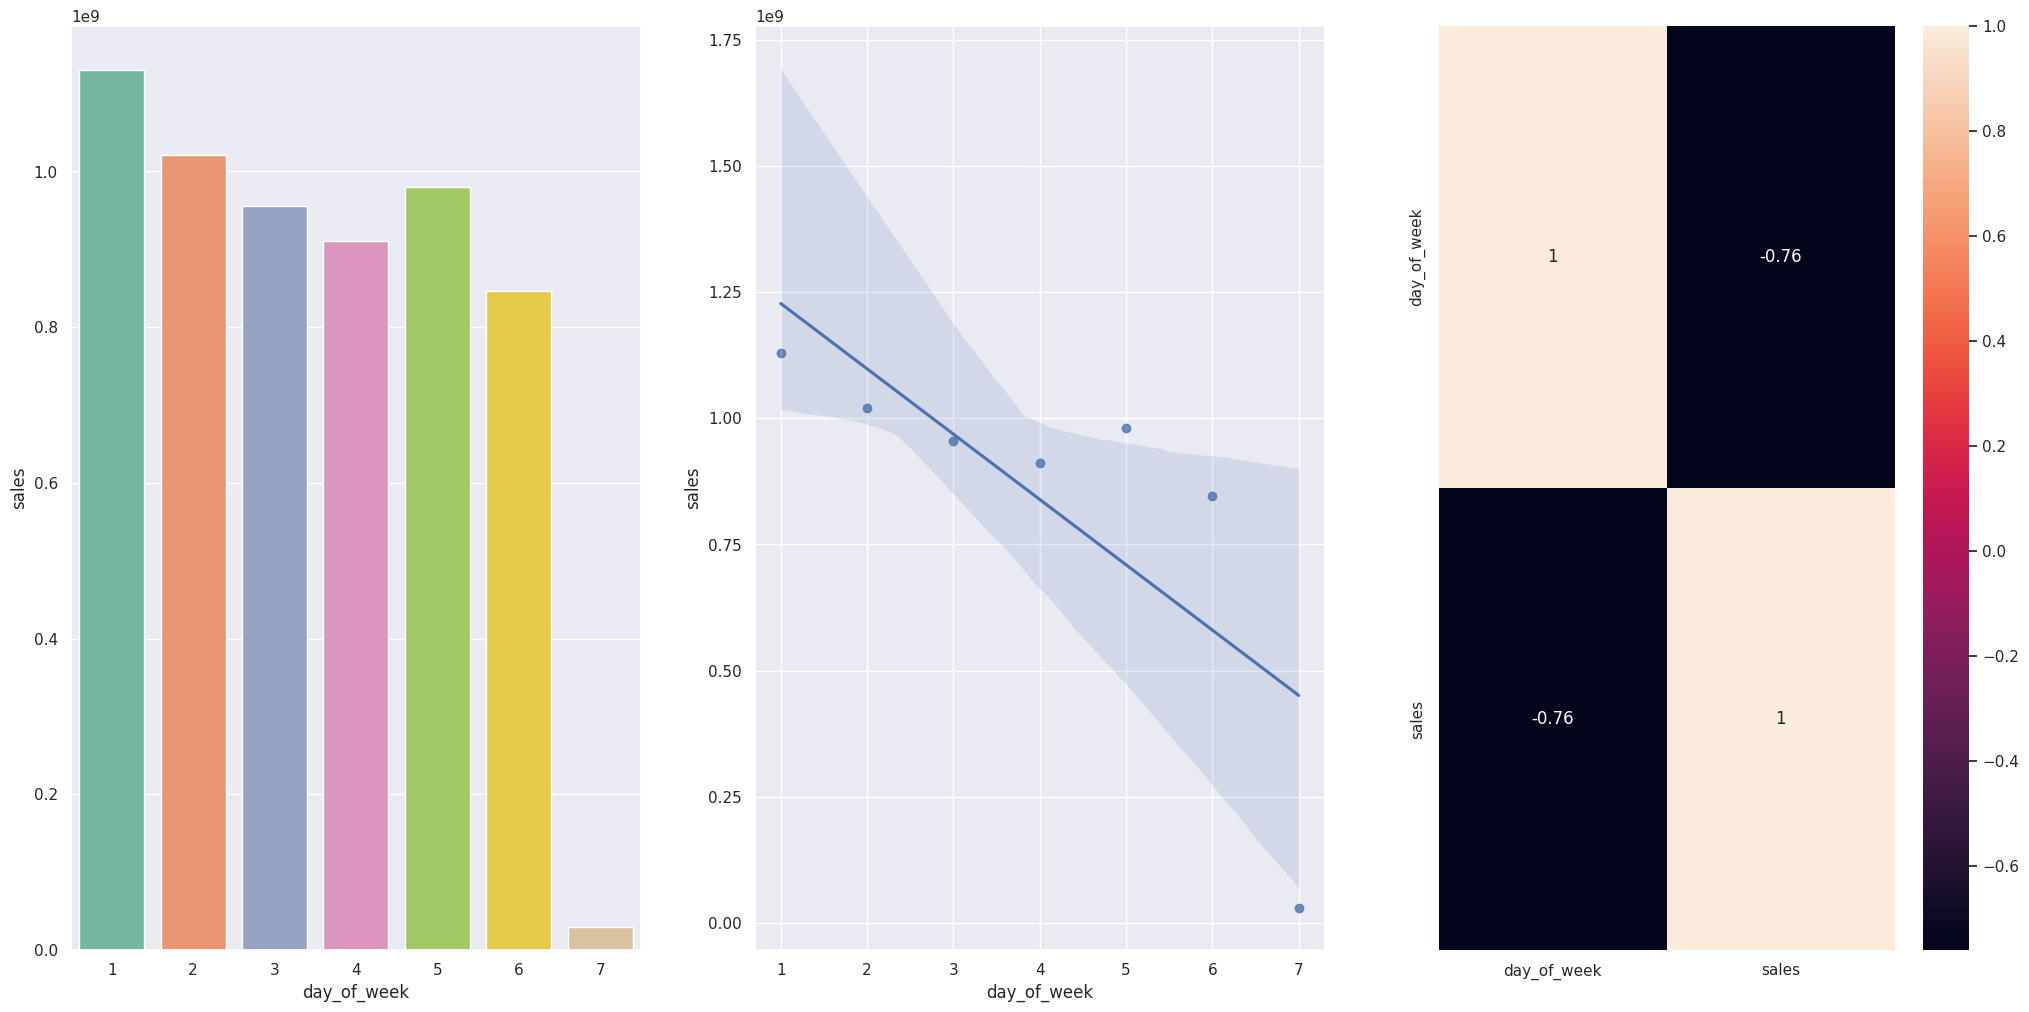

In [64]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x= 'day_of_week', y= 'sales', data= aux1, palette=palette);
plt.subplot(1,3,2)
sns.regplot(x= 'day_of_week', y= 'sales', data= aux1);
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True)

### H13. Lojas deveriam vender menos durante os feriados escolares.
* Verdadeira. As lojas vendem menos nos feriados escolares, exceto julho e agosto.

<ipython-input-65-cff86626c39f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= 'school_holiday', y= 'sales', data= aux1, palette=palette);
<ipython-input-65-cff86626c39f>:3: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.barplot(x= 'school_holiday', y= 'sales', data= aux1, palette=palette);
<ipython-input-65-cff86626c39f>:6: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.barplot(x= 'month', y= 'sales',hue='school_holiday', data= aux2, palette=palette);


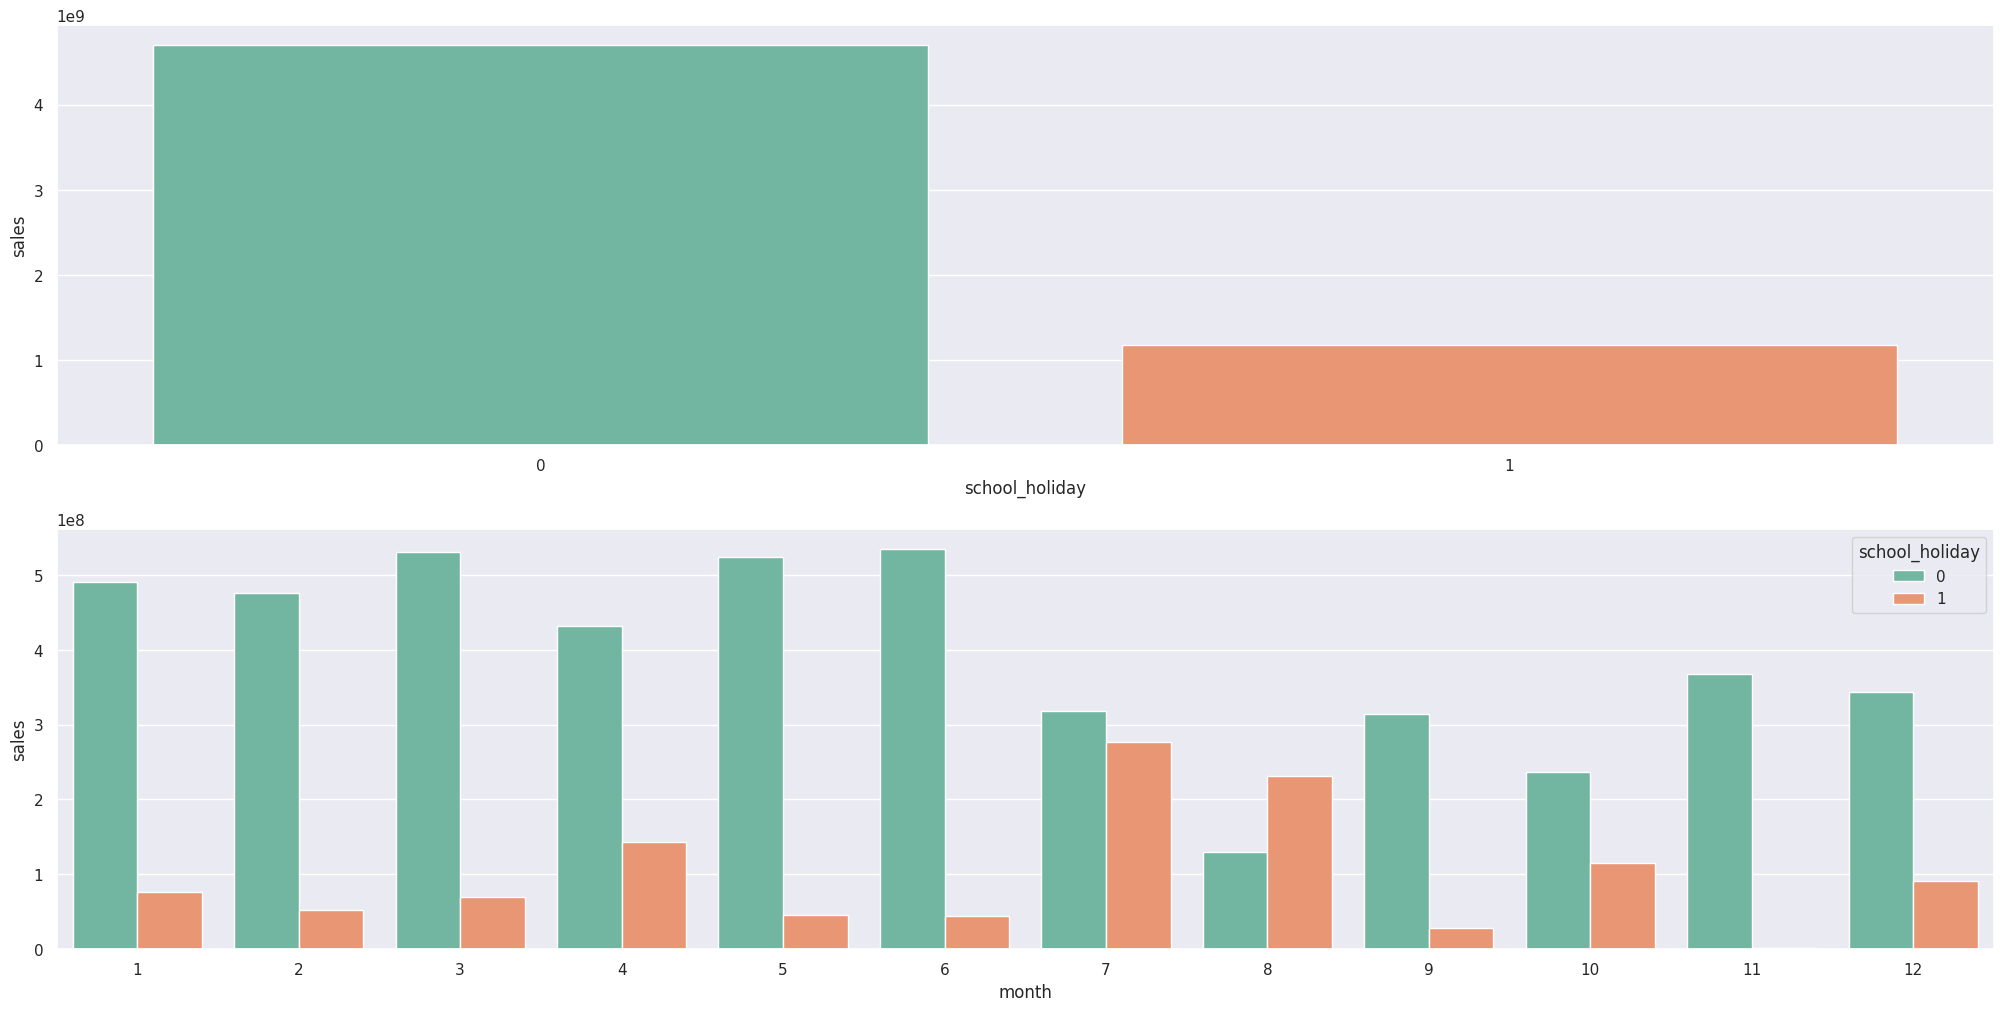

In [65]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x= 'school_holiday', y= 'sales', data= aux1, palette=palette);
plt.subplot(2,1,2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x= 'month', y= 'sales',hue='school_holiday', data= aux2, palette=palette);

### 4.2.1 Resumo das hipóteses

In [66]:
from tabulate import tabulate

In [67]:
tab = [['Hipóteses', 'Conclusão', 'Relevância'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Média'],
       ['H3', 'Falsa', 'Média'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H7', 'Falsa', 'Baixa'],
       ['H8', 'Falsa', 'Média'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Falsa', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Alta'],
       ['H13', 'Verdadeira', 'Baixa']
       ]
print(tabulate(tab, headers= 'firstrow'))

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Média
H3           Falsa        Média
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Média
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Análise multivariada

In [68]:
df4.dtypes

,0
store,int64
day_of_week,int64
date,datetime64[ns]
sales,int64
promo,int64
state_holiday,object
school_holiday,int64
store_type,object
assortment,object
competition_distance,float64


In [69]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64','datetime64[ns]'] )

### 4.3.1 Atributos numéricos

<Axes: >

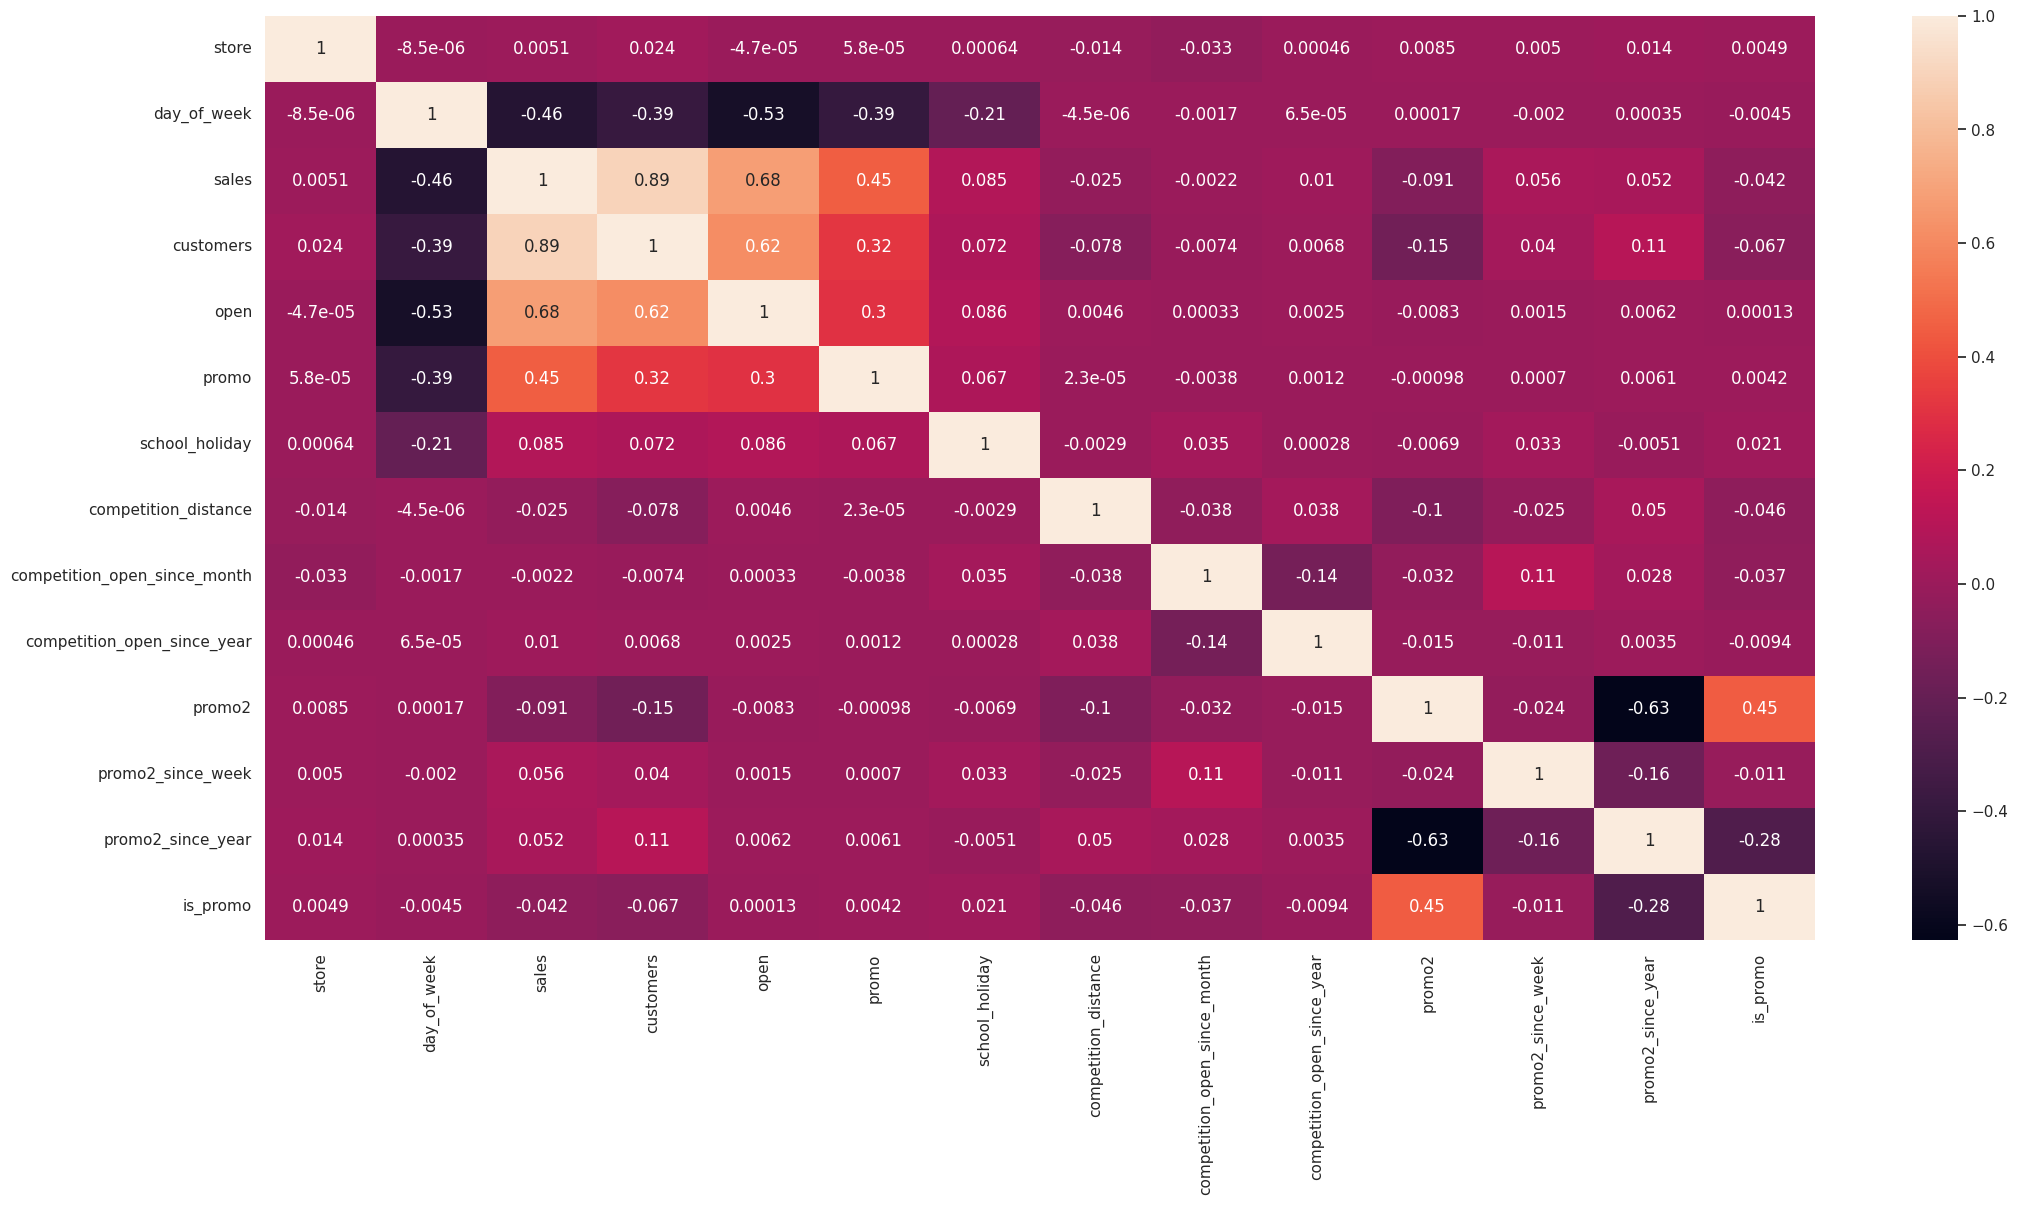

In [70]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot = True)

### 4.3.2 Atibutos categóricos

In [71]:
a = df4.select_dtypes(include=['object'])

In [72]:
cramer_v(a['state_holiday'], a['store_type'])

0.07106469715258833

<Axes: >

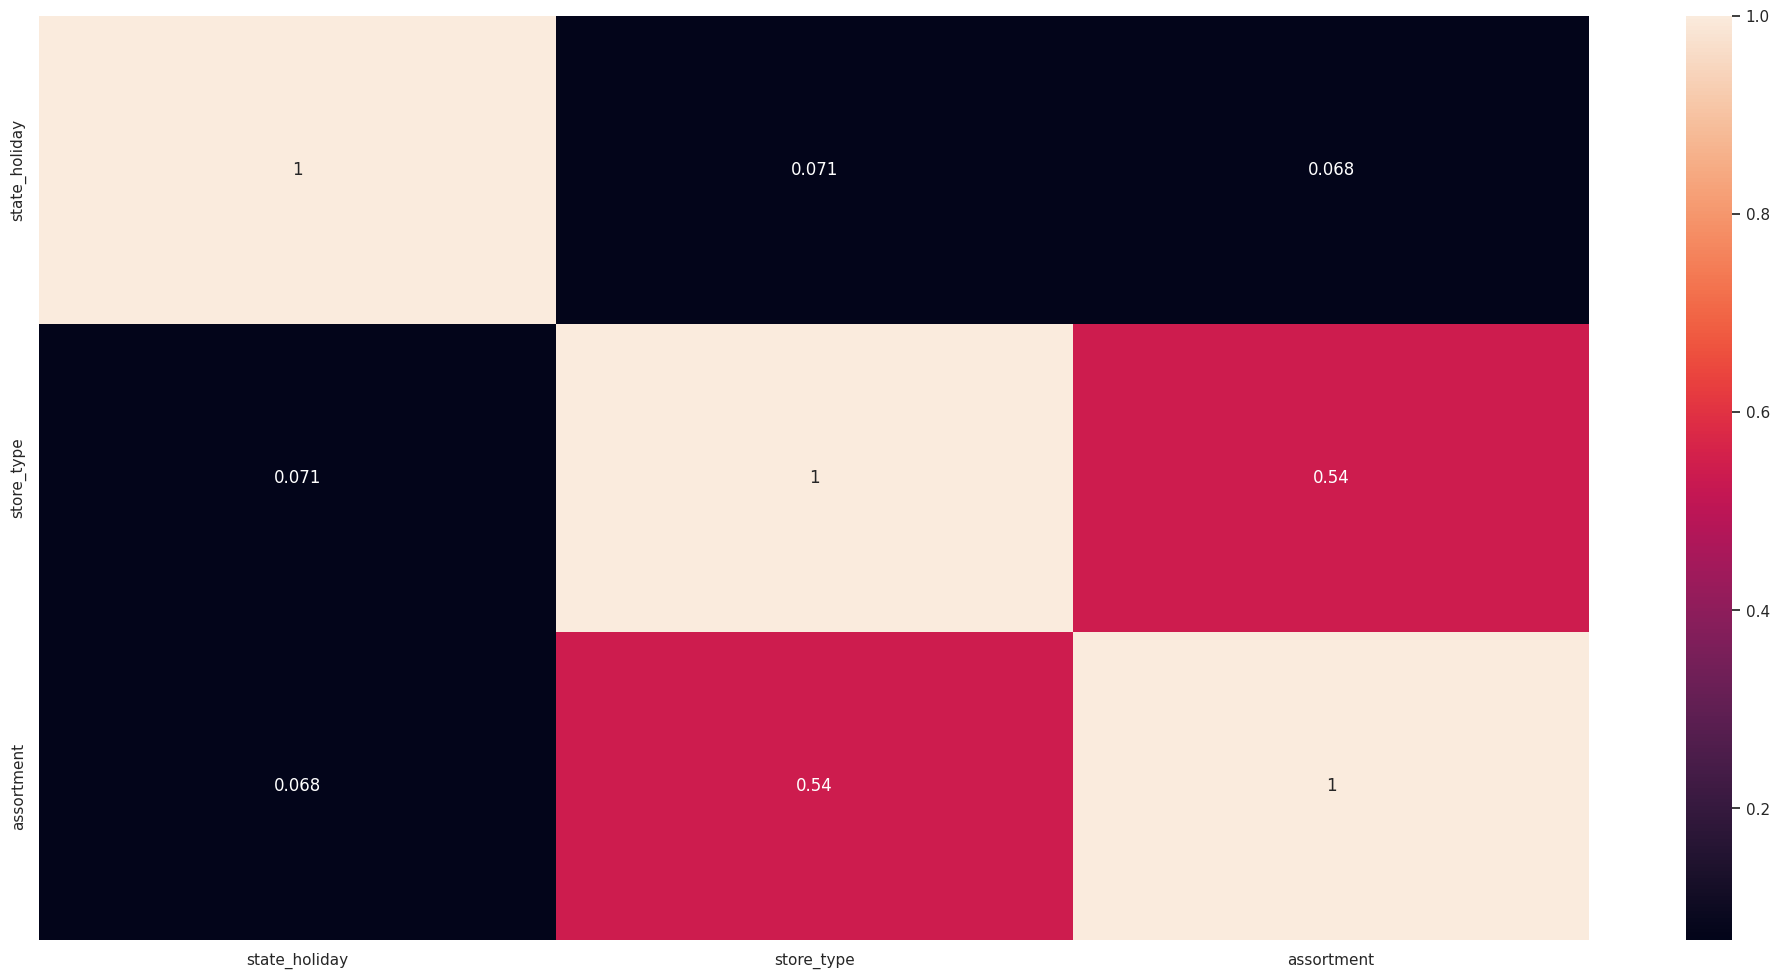

In [73]:
# only categorical data
a = df4.select_dtypes(include=['object'])

# calculate Cramer's V

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

sns.heatmap(d, annot = True)

# 5.0 Passo 05 - Data Preparation

In [84]:
df5 = df4.copy()

## 5.1 Normalizacao
* Não será usada pois não há features com comportamento de distibuição normal.

## 5.2 Rescaling

In [75]:
a = df5.select_dtypes(include=['int64', 'float64', 'int32'])

In [78]:
rs = RobustScaler()
mms = MinMaxScaler()
#competition distance
df5['competition_distance']=rs.fit_transform(df5[['competition_distance']].values)
#competition time month
df5['competition_time_month']=rs.fit_transform(df5[['competition_time_month']].values)
#promo time week
df5['promo_time_week']=mms.fit_transform(df5[['promo_time_week']].values)
#year
df5['year']=mms.fit_transform(df5[['year']].values)

## 5.3 Tranformacao

### 5.3.1 Encoding

In [87]:
#state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix= ['state_holiday'], columns = ['state_holiday'], dtype='int32' )
#store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
#assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)